In [ ]:
%pip install torch

In [3]:
import torch
import torch.nn as nn

In [75]:
class PatchEmbed(nn.Module):
    """
    Patch embedding module.
    Splits the image into non-overlapping patches and then embeds them.

    Parameters:
    - in_channels: Number of input channels
    - patch_size: Size of the patch
    - emb_size: Size of the embedding (after the patch embedding)
    - img_size: Size of the image (image has to be square)

    Attributes:
    - n_patches: Number of patches inside a single image
    - projection: Convolutional layer that does both the splitting into patches and the embedding
    
    """

    def __init__(self, img_size, in_channels=3, patch_size = 16 , emb_size=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        self.projection = nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size)
    
    def forward(self, x):
        """
        Perform the forward pass of the PatchEmbed module.
        
        Parameters:
        x : torch.Tensor.Shape (n_samples, in_channels, img_size, img_size)

        Returns:
        torch.Tensor.Shape (n_samples, n_patches, emb_size)

        """
        x = self.projection(x) # (n_samples, emb_size, n_patches ** 0.5, n_patches ** 0.5)
        x = x.flatten(2) # (n_samples, emb_size, n_patches)
        x = x.transpose(1, 2) # (n_samples, n_patches, emb_size)
        return x
    
class Attention(nn.Module):
    """
    Attention module.
    
    Parameters:
    - emb_size: Size of the embedding (input and out dimension of per token features)
    - n_heads: Number of attention heads
    -drop_prob_qkv: Dropout rate to apply to the query, key and value tensors
    - drop_prob_o: Dropout rate after the softmax layer
    -qkv_bias: Whether to include bias in the qkv projection layers
    - causal: Whether to apply causal masking or not
    
    Attributes:
    - scales: Precomputed square root of the head_dim
    - qkv: Linear layer for the query, key and value
    - proj_qkv: linear mapping that takes in concatenated output of all heads and projects it back to new space
    - dropout_qkv, dropout_o: Dropout layer

    
    """
    
    def __init__(self, emb_size, n_heads = 12, drop_prob_o = 0.,drop_prob_qkv = 0., qkv_bias = True):
        super().__init__()
        self.emb_size = emb_size
        self.n_heads = n_heads
        self.head_dim = emb_size // n_heads
        assert self.head_dim * n_heads == emb_size, "Embedding size should be divisible by the number of heads"
        self.scales = self.head_dim ** -0.5
        self.qkv = nn.Linear(emb_size, emb_size * 3, bias = qkv_bias) # q, k, v
        self.dropout_qkv = nn.Dropout(drop_prob_qkv)
        self.proj_qkv = nn.Linear(emb_size, emb_size)
        self.dropout_o = nn.Dropout(drop_prob_o)
        
    def forward(self, x):
        """
        Perform the forward pass of the Attention module.
        
        Parameters:
        x : torch.Tensor.Shape (n_samples, n_patches + 1, emb_size)

        Returns:
        torch.Tensor.Shape (n_samples, n_patches + 1, emb_size)

        """
        
        n_samples, n_tokens, emb_size = x.shape
        if emb_size != self.emb_size:
            raise ValueError(f"Attention expects {self.emb_size} input features, but got {emb_size}")
        qkv = self.qkv(x).reshape(n_samples, n_tokens, 3, self.n_heads, self.head_dim) # (n_samples, n_patches + 1, 3 * dim), (n_samples, n_patches + 1, 3, n_heads, head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4) # (3, n_samples, n_heads, n_patches + 1, head_dim)
        q, k, v = qkv[0], qkv[1], qkv[2]
        k_t = k.transpose(-2, -1) # (n_samples, n_heads, head_dim, n_patches + 1)
        dots = (q @ k_t) * self.scales # (n_samples, n_heads, n_patches + 1, n_patches + 1)
        attn = dots.softmax(dim=-1) # (n_samples, n_heads, n_patches + 1, n_patches + 1)
        attn = self.dropout_qkv(attn)
        weighted_avg = attn @ v # (n_samples, n_heads, n_patches + 1, head_dim)
        weighted_avg = weighted_avg.transpose(1, 2) # (n_samples, n_patches + 1, n_heads, head_dim)
        weighted_avg = weighted_avg.flatten(2) # (n_samples, n_patches + 1, emb_size)
        x = self.proj_qkv(weighted_avg) # (n_samples, n_patches + 1, emb_size)
        x = self.dropout_o(x)
        return x
        
class MLP(nn.Module):
    """
    MLP module.

    Parameters:
    - in_features: Number of input features
    - hidden_features: Number of hidden layer features
    - out_features: Number of output features
    - drop_prob: Dropout rate to apply

    Attributes:
    - fc1, fc2: Linear layers -> nn.Linear(in_features, hidden_features), nn.Linear(hidden_features, out_features)
    - act_fn: GELU activation function -> nn.GELU()
    - dropout: Dropout layer -> nn.Dropout(drop_prob)

    """
    def __init__(self, in_features, hidden_features, out_features, drop_prob = 0.):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act_fn = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.dropout = nn.Dropout(drop_prob)

    def forward(self, x):
        """
        Perform the forward pass of the MLP module.
        
        Parameters:
        x : torch.Tensor.Shape (n_samples, n_patches + 1, emb_size or input_features)

        Returns:
        torch.Tensor.Shape (n_samples, n_patches + 1, emb_size or out_features)

        """
        x = self.fc1(x) # (n_samples, n_patches + 1, hidden_features)
        x = self.act_fn(x) # (n_samples, n_patches + 1, hidden_features)
        x = self.dropout(x) # (n_samples, n_patches + 1, hidden_features)
        x = self.fc2(x) # (n_samples, n_patches + 1, out_features)
        x = self.dropout(x) # (n_samples, n_patches + 1, out_features)  # here out_features are same as hidden_features

        return x
    
class Block(nn.Module):
    """
    Transformer block.

    Parameters:
    - emb_size: Size of the input embedding
    - n_heads: Number of attention heads
    - mlp_ratio: Multiplier for the hidden dim of the MLP wrt the input embedding
    - qkv_bias: Whether to include bias in the qkv projection layers
    - drop_prob: Dropout rate to apply
    - attn_drop_prob: Dropout rate to apply to the attention module

    Attributes:
    - norm1, norm2: LayerNorms  # Layer norm makes sure that the mean of each sample is 0 and the standard deviation is 1
    - attn: Attention module
    - mlp: MLP module

    """
    def __init__(self, emb_size, n_heads, mlp_ratio = 4., qkv_bias = True, drop_prob = 0., attn_drop_prob = 0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(emb_size, eps=1e-6)
        self.attn = Attention(emb_size, n_heads, drop_prob_o = attn_drop_prob, drop_prob_qkv = attn_drop_prob, qkv_bias = qkv_bias)
        self.norm2 = nn.LayerNorm(emb_size, eps=1e-6)
        hidden_features = int(emb_size * mlp_ratio)
        self.mlp = MLP(emb_size, hidden_features, emb_size, drop_prob)

    def forward(self, x):
        """
        Perform the forward pass of the Block module.
        
        Parameters:
        x : torch.Tensor.Shape (n_samples, n_patches + 1, emb_size)

        Returns:
        torch.Tensor.Shape (n_samples, n_patches + 1, emb_size)

        """
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x
    
class VisionTransformer(nn.Module):
    """
    Vision Transformer.

    Parameters:
    - img_size: Size of the image (image has to be square)
    - patch_size: Size of the patch
    - in_channels: Number of input channels
    - n_classes: Number of output classes
    - emb_size: Size of the token/patch embedding
    - depth: Number of transformer blocks
    - n_heads: Number of attention heads
    - mlp_ratio: Multiplier for the hidden dim of the MLP wrt the input embedding
    - qkv_bias: Whether to include bias in the qkv projection layers
    - drop_prob: Dropout rate to apply
    - attn_drop_prob: Dropout rate to apply to the attention module

    Attributes:
    - patch_embed: PatchEmbed module
    - cls_token: Learnable parameter that will represent the whole image or 1st token in sequence.
    - pos_embed: Positional embedding of cls token + all the patches and it has (n_patches + 1)* emb_size elements.
    - pos_drop: Dropout layer
    - blocks: Sequence of the transformer blocks
    - norm: Layer norm

    """
    def __init__(self, img_size = 384, patch_size = 16, in_channels = 3, n_classes = 1000, emb_size = 768, depth = 12, n_heads = 12, mlp_ratio = 4., qkv_bias = True, drop_prob = 0., attn_drop_prob = 0.):
        super().__init__()
        self.patch_embed = PatchEmbed(img_size, in_channels, patch_size, emb_size)
        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_size))
        self.pos_embed = nn.Parameter(torch.randn(1, 1 + self.patch_embed.n_patches, emb_size))
        self.pos_drop = nn.Dropout(drop_prob)
        self.blocks = nn.ModuleList([Block(emb_size, n_heads, mlp_ratio, qkv_bias, drop_prob, attn_drop_prob) for _ in range(depth)])
        self.norm = nn.LayerNorm(emb_size, eps=1e-6)
        self.head = nn.Linear(emb_size, n_classes)

    def forward(self, x):
        """
        Perform the forward pass of the VisionTransformer module.
        
        Parameters:
        x : torch.Tensor.Shape (n_samples, in_channels, img_size, img_size)

        Returns:
        torch.Tensor.Shape (n_samples, n_classes) logits over all the classes

        """
        n_samples = x.shape[0]
        x = self.patch_embed(x)
        cls_token = self.cls_token.expand(n_samples, -1, -1) # (n_samples, 1, emb_size)
        x = torch.cat((cls_token, x), dim=1) # (n_samples, 1 + n_patches, emb_size)
        x = x + self.pos_embed # (n_samples, 1 + n_patches, emb_size)
        x = self.pos_drop(x)
        for block in self.blocks:
            x = block(x)
        x = self.norm(x)
        cls_token_final = x[:, 0]
        x = self.head(cls_token_final)
        return x

In [264]:
class VisionTransformer(nn.Module):
    """
    The vision transformer.
    Parameters:
    image_size: int, the size of the image (it is a square).
    patch_size: int, the size of the patch (it is a square).
    in_channels: int, the number of input channels.
    num_classes: int, the number of classes.
    embed_dim: int, the dimension of the embedding.
    depth: int, the depth of the transformer.
    num_heads: int, the number of attention heads.
    mlp_hidden_features: int, the number of hidden features in the MLP.
    attention_dropout: float, the dropout rate for the attention.
    projection_dropout: float, the dropout rate for the projection.
    mlp_dropout: float, the dropout rate for the MLP.

    Attributes:
    patch_embedding: PatchEmbedding, the patch embedding layer.
    transformer: nn.ModuleList, the list of transformer blocks.
    norm: nn.LayerNorm, the layer normalization.
    mlp_head: nn.Linear, the linear layer for the classification.
    """

    def __init__(self, img_size = 384, patch_size = 16, in_channels = 3, n_classes = 1000, emb_size = 768, depth = 12, n_heads = 12, mlp_ratio = 4., qkv_bias = True, drop_prob = 0., attn_drop_prob = 0.):
        super().__init__()
        self.patch_embed = PatchEmbed(img_size, in_channels, patch_size, emb_size)
        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_size))
        self.pos_embed = nn.Parameter(torch.randn(1, 1 + self.patch_embed.n_patches, emb_size))
        self.pos_drop = nn.Dropout(drop_prob)
        self.blocks = nn.ModuleList([Block(emb_size, n_heads, mlp_ratio, qkv_bias, drop_prob, attn_drop_prob) for _ in range(depth)])
        self.norm = nn.LayerNorm(emb_size, eps=1e-6)
        self.head = nn.Linear(emb_size, n_classes)

    def forward(self, x, layer_idx=-1):
        """
        Forward method.
        Args:
        x: torch.Tensor, the input tensor.

        Returns:
        x: torch.Tensor, the output tensor.
        """
        n_samples = x.shape[0]
        x = self.patch_embed(x)
        cls_token = self.cls_token.expand(n_samples, -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        x += self.pos_embed
        x = self.pos_drop(x)
        cls_token = [x[:, 0]]
        for idx, transformer in enumerate(self.blocks):
            x = transformer(x)
            if idx == layer_idx:
                cls_token.append(x[:, 0])
                
        x = self.norm(cls_token[-1])
        cls_token_final = x
        # print(cls_token_final.shape)
        x = self.head(cls_token_final)
        return x

In [235]:
torch.save(model_custom.state_dict(), "vit_custom.pth")

In [265]:
model_custom = VisionTransformer(**custom_config)

In [256]:
def get_cifar_dataloaders(batch_size):
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Resize((32, 32)),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

    testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

    return trainloader, testloader

In [261]:
def layer_results(model, device):

    model.eval()
    trainloader, testloader = get_cifar_dataloaders(batch_size=128)
    
    # calculate the accuracy at each layer
    accuracies = []
    for layer_idx in range(12):
        correct = 0
        total = 0
        with torch.no_grad():
            for data in testloader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                outputs = model(images, layer_idx)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracies.append(100 * correct / total)
    return accuracies




In [266]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_custom.load_state_dict(torch.load("vit_custom.pth"))

<All keys matched successfully>

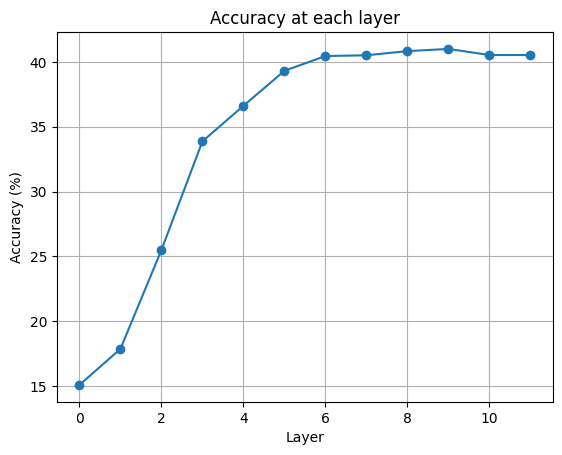

In [269]:
# plot the results
import matplotlib.pyplot as plt

# accuracies = layer_results(model_custom, device)
plt.plot(accuracies, marker='o')
plt.xlabel('Layer')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy at each layer')
plt.grid()
plt.show()


In [267]:
accuracies = layer_results(model_custom, device)

Files already downloaded and verified
Files already downloaded and verified


In [268]:
accuracies

[15.08,
 17.86,
 25.49,
 33.87,
 36.61,
 39.31,
 40.45,
 40.51,
 40.83,
 41.0,
 40.53,
 40.53]

In [120]:
custom_config = {"img_size": 32, "patch_size": 4, "in_channels": 3, "n_classes": 10, "emb_size": 48, "depth": 12, "n_heads": 4, "mlp_ratio": 4., "qkv_bias": True, "drop_prob": 0.3, "attn_drop_prob": 0.3}

In [121]:
model_custom = VisionTransformer(**custom_config)

In [122]:
model_custom.eval()

VisionTransformer(
  (patch_embed): PatchEmbed(
    (projection): Conv2d(3, 48, kernel_size=(4, 4), stride=(4, 4))
  )
  (pos_drop): Dropout(p=0.3, inplace=False)
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((48,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=48, out_features=144, bias=True)
        (dropout_qkv): Dropout(p=0.3, inplace=False)
        (proj_qkv): Linear(in_features=48, out_features=48, bias=True)
        (dropout_o): Dropout(p=0.3, inplace=False)
      )
      (norm2): LayerNorm((48,), eps=1e-06, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=48, out_features=192, bias=True)
        (act_fn): GELU(approximate='none')
        (fc2): Linear(in_features=192, out_features=48, bias=True)
        (dropout): Dropout(p=0.3, inplace=False)
      )
    )
  )
  (norm): LayerNorm((48,), eps=1e-06, elementwise_affine=True)
  (head): Linear(in_features=48, out_features=10, bia

In [123]:
inp = torch.randn(1, 3, 32, 32)
res_c = model_custom(inp)

In [104]:
torch.save(model_custom.state_dict(), "vit_custom.pth")

In [87]:
from tqdm import tqdm

In [124]:
# train model on CIFAR-10
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

from torchvision import datasets, transforms

def get_cifar_dataloaders(batch_size):
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Resize((32, 32)),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

    testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

    return trainloader, testloader

def train_model(model, trainloader, n_epochs, lr):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    # print(len(trainloader))
    for epoch in tqdm(range(n_epochs)):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            # if i % 2 == 0:    # print every 2000 mini-batches
            #     print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            #     running_loss = 0.0

    print('Finished Training')

trainloader, testloader = get_cifar_dataloaders(64)




Files already downloaded and verified
Files already downloaded and verified


In [126]:
# print accuracy on test set
def test_model(model, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

In [127]:
test_model(model_custom, testloader)

Accuracy of the network on the 10000 test images: 60 %


In [125]:
train_model(model_custom, trainloader, 20, 0.001)

100%|██████████| 20/20 [1:20:43<00:00, 242.17s/it]

Finished Training


In [99]:
torch.cuda.device_count()

0

In [128]:
def get_cifar_dataloaders(batch_size, train_size=0.8):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((32, 32)),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

    # Split the trainset into training and validation sets
    train_size = int(train_size * len(trainset))
    valid_size = len(trainset) - train_size
    trainset, validset = torch.utils.data.random_split(trainset, [train_size, valid_size])

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
    validloader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=False, num_workers=2)

    testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

    return trainloader, validloader, testloader

In [130]:
import matplotlib.pyplot as plt

def train_model(model, trainloader, validloader, testloader, n_epochs, lr, device):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.to(device)
    
    train_loss_history = []
    valid_loss_history = []
    train_acc_history = []
    valid_acc_history = []

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        correct_valid = 0
        total_valid = 0
        
        # Training phase
        model.train()
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total_train += labels.size(0)
            correct_train += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_accuracy = 100 * correct_train / total_train
        
        # Validation phase
        model.eval()
        running_loss = 0.0
        with torch.no_grad():
            for data in validloader:
                inputs, labels = data[0].to(device), data[1].to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total_valid += labels.size(0)
                correct_valid += predicted.eq(labels).sum().item()

        valid_loss = running_loss / len(validloader)
        valid_accuracy = 100 * correct_valid / total_valid
        
        # Print training and validation loss and accuracy
        print('[Epoch %d/%d] Train Loss: %.4f, Train Acc: %.2f%% | Valid Loss: %.4f, Valid Acc: %.2f%%' % (
            epoch + 1, n_epochs, train_loss, train_accuracy, valid_loss, valid_accuracy))
        
        # Save loss and accuracy history for plotting
        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)
        train_acc_history.append(train_accuracy)
        valid_acc_history.append(valid_accuracy)

    print('Finished Training')
    
    # Test phase
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total_test += labels.size(0)
            correct_test += predicted.eq(labels).sum().item()

    test_accuracy = 100 * correct_test / total_test
    print('Test Accuracy: %.2f%%' % test_accuracy)
    
    # Plotting loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss_history, label='Training Loss')
    plt.plot(valid_loss_history, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
    
    # Plotting accuracy curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_acc_history, label='Training Accuracy')
    plt.plot(valid_acc_history, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

# Example usage:
# train_model(model, trainloader, validloader, testloader, n_epochs=10, lr=0.001, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))


In [164]:
# Set device to GPU if available
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the model, optimizer, and training parameters
# model = YourModel()
# model.to(device)
batch_size = 128
lr = 0.001
n_epochs = 10

# Get data loaders
trainloader, validloader, testloader = get_cifar_dataloaders(batch_size, train_size=0.8)

Files already downloaded and verified
Files already downloaded and verified


In [163]:
custom_config = {"img_size": 32, "patch_size": 4, "in_channels": 3, "n_classes": 10, "emb_size": 48, "depth": 12, "n_heads": 4, "mlp_ratio": 4., "qkv_bias": True, "drop_prob": 0.3, "attn_drop_prob": 0.3}

[Epoch 1/2] Train Loss: 2.0171, Train Acc: 24.04% | Valid Loss: 1.8256, Valid Acc: 33.32%
[Epoch 2/2] Train Loss: 1.7929, Train Acc: 33.81% | Valid Loss: 1.6300, Valid Acc: 40.14%
Finished Training
Test Accuracy: 40.53%


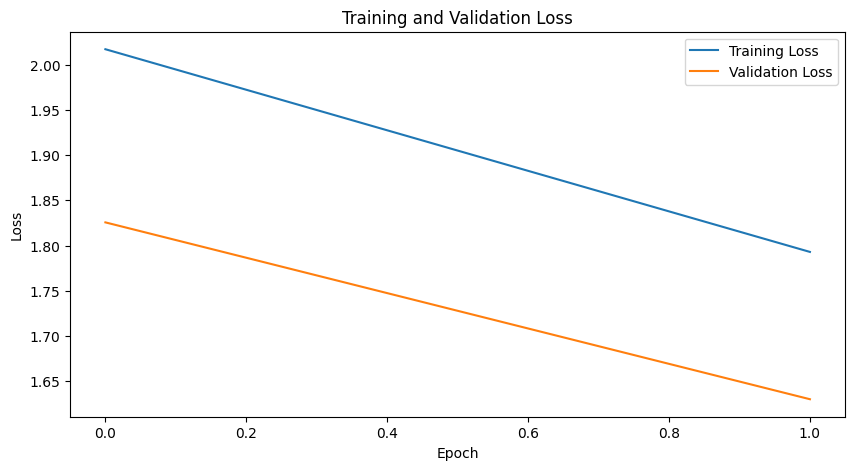

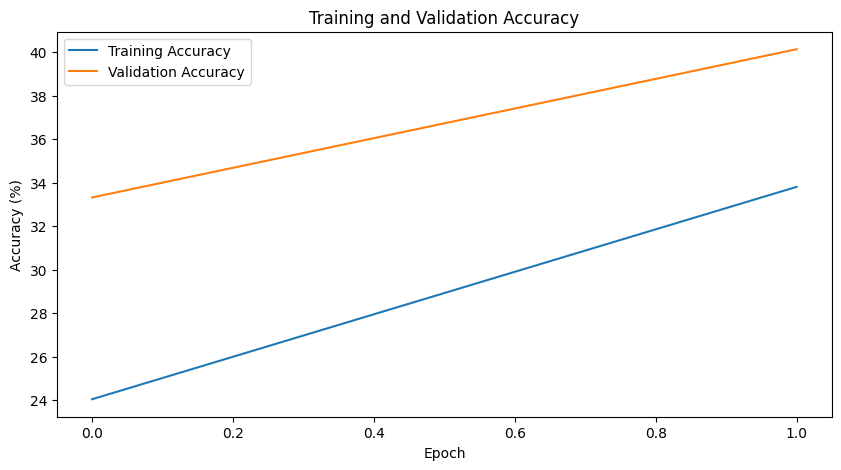

In [165]:
model_custom = VisionTransformer(**custom_config)
train_model(model_custom, trainloader, validloader, testloader, n_epochs=2, lr=0.001, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

In [185]:
model_custom

VisionTransformer(
  (patch_embed): PatchEmbed(
    (projection): Conv2d(3, 48, kernel_size=(4, 4), stride=(4, 4))
  )
  (pos_drop): Dropout(p=0.3, inplace=False)
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((48,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=48, out_features=144, bias=True)
        (dropout_qkv): Dropout(p=0.3, inplace=False)
        (proj_qkv): Linear(in_features=48, out_features=48, bias=True)
        (dropout_o): Dropout(p=0.3, inplace=False)
      )
      (norm2): LayerNorm((48,), eps=1e-06, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=48, out_features=192, bias=True)
        (act_fn): GELU(approximate='none')
        (fc2): Linear(in_features=192, out_features=48, bias=True)
        (dropout): Dropout(p=0.3, inplace=False)
      )
    )
  )
  (norm): LayerNorm((48,), eps=1e-06, elementwise_affine=True)
  (head): Linear(in_features=48, out_features=10, bia

# EXPERIMENT 2

In [ ]:
train_size = [0.05, 0.1, 0.25, 0.5, 1]
for size in train_size:
    trainloader, validloader, testloader = get_cifar_dataloaders(batch_size, train_size=size)
    model_custom = VisionTransformer(**custom_config)
    train_model(model_custom, trainloader, validloader, testloader, n_epochs=10, lr=0.001, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))


# EXPERIMENT 3

In [ ]:
trainloader, validloader, testloader = get_cifar_dataloaders(batch_size, train_size=size)

In [ ]:
# try different patch sizes and embedding sizes for both overlapping and non-overlapping patches
patch_sizes = [4, 8, 16]
emb_sizes = [48, 96, 192]
for patch_size in patch_sizes:
    for emb_size in emb_sizes:
        custom_config = {"img_size": 32, "patch_size": patch_size, "in_channels": 3, "n_classes": 10, "emb_size": emb_size, "depth": 12, "n_heads": 4, "mlp_ratio": 4., "qkv_bias": True, "drop_prob": 0.3, "attn_drop_prob": 0.3}
        model_custom = VisionTransformer(**custom_config)
        train_model(model_custom, trainloader, validloader, testloader, n_epochs=10, lr=0.001, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# EXPERIMENT 4

In [ ]:
# try different number of heads
n_heads = [4, 8, 12]
for heads in n_heads:
    custom_config = {"img_size": 32, "patch_size": 4, "in_channels": 3, "n_classes": 10, "emb_size": 48, "depth": 12, "n_heads": heads, "mlp_ratio": 4., "qkv_bias": True, "drop_prob": 0.3, "attn_drop_prob": 0.3}
    model_custom = VisionTransformer(**custom_config)
    train_model(model_custom, trainloader, validloader, testloader, n_epochs=10, lr=0.001, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# EXPERIMENT 5

In [ ]:
# classify the model using cls token from different layers
depths = [2, 4, 6, 8, 10, 12]
for depth in depths:
    custom_config = {"img_size": 32, "patch_size": 4, "in_channels": 3, "n_classes": 10, "emb_size": 48, "depth": depth, "n_heads": 4, "mlp_ratio": 4., "qkv_bias": True, "drop_prob": 0.3, "attn_drop_prob": 0.3}
    model_custom = VisionTransformer(**custom_config)
    train_model(model_custom, trainloader, validloader, testloader, n_epochs=10, lr=0.001, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

In [ ]:
# classify the model at 1st token from different layers 
# forward pass the model and classify after 1st attention block, 2nd attention block, 3rd attention block, etc.

class VisionTransformer(nn.Module):
    """
    Vision Transformer.

    Parameters:
    - img_size: Size of the image (image has to be square)
    - patch_size: Size of the patch
    - in_channels: Number of input channels
    - n_classes: Number of output classes
    - emb_size: Size of the token/patch embedding
    - depth: Number of transformer blocks
    - n_heads: Number of attention heads
    - mlp_ratio: Multiplier for the hidden dim of the MLP wrt the input embedding
    - qkv_bias: Whether to include bias in the qkv projection layers
    - drop_prob: Dropout rate to apply
    - attn_drop_prob: Dropout rate to apply to the attention module

    Attributes:
    - patch_embed: PatchEmbed module
    - cls_token: Learnable parameter that will represent the whole image or 1st token in sequence.
    - pos_embed: Positional embedding of cls token + all the patches and it has (n_patches + 1)* emb_size elements.
    - pos_drop: Dropout layer
    - blocks: Sequence of the transformer blocks
    - norm: Layer norm

    """
    def __init__(self, img_size = 384, patch_size = 16, in_channels = 3, n_classes = 1000, emb_size = 768, depth = 12, n_heads = 12, mlp_ratio = 4., qkv_bias = True, drop_prob = 0., attn_drop_prob = 0.):
        super().__init__()
        self.patch_embed = PatchEmbed(img_size, in_channels, patch_size, emb_size)
        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_size))
        self.pos_embed = nn.Parameter(torch.randn(1, 1 + self.patch_embed.n_patches, emb_size))
        self.pos_drop = nn.Dropout(drop_prob)
        self.blocks = nn.ModuleList([Block(emb_size, n_heads, mlp_ratio, qkv_bias, drop_prob, attn_drop_prob) for _ in range(depth)])
        self.norm = nn.LayerNorm(emb_size, eps=1e-6)
        self.head = nn.Linear(emb_size, n_classes)

    def forward(self, x, depth):
        """
        Perform the forward pass of the VisionTransformer module.
        
        Parameters:
        x : torch.Tensor.Shape (n_samples, in_channels, img_size, img_size)
        """
        n_samples = x.shape[0]
        x = self.patch_embed(x)
        cls_token = self.cls_token.expand(n_samples, -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        x = x + self.pos_embed
        x = self.pos_drop(x)
        for i, block in enumerate(self.blocks):
            x = block(x)
            if i == depth:
                break
        x = self.norm(x)
        cls_token_final = x[:, 0]
        x = self.head(cls_token_final)
        return x
    


# EXPERIMENT 6

In [ ]:
import numpy as np

In [166]:
import cv2

def plot_attention_over_image(model, dataloader, n_heads=4, n_rows=2, n_cols=2, num_images_per_class=2):
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    images_per_class = {}
    
    # Collect 2 images per class
    for images, labels in dataloader:
        for image, label in zip(images, labels):
            class_id = label.item()
            if class_id not in images_per_class:
                images_per_class[class_id] = []
            if len(images_per_class[class_id]) < num_images_per_class:
                images_per_class[class_id].append(image)
            if all(len(images) == num_images_per_class for images in images_per_class.values()):
                break
        if all(len(images) == num_images_per_class for images in images_per_class.values()):
            break
    
    # Prepare images for visualization
    images_to_visualize = torch.stack([image for images in images_per_class.values() for image in images])
    labels_to_visualize = torch.tensor([class_id for class_id in images_per_class.keys() for _ in range(num_images_per_class)])
    
    for images, labels in zip(images_to_visualize, labels_to_visualize):
        # Move images to device
        images = images.unsqueeze(0).to(device)
        
        # Compute attention maps
        with torch.no_grad():
            outputs = model.patch_embed(images)
            cls_token = model.cls_token.expand(images.size(0), -1, -1)
            outputs = torch.cat((cls_token, outputs), dim=1)
            outputs = outputs + model.pos_embed
            outputs = model.pos_drop(outputs)
            for i, block in enumerate(model.blocks):
                outputs = block.attn(outputs)
                if i + 1 in [1, 2, 3, 4]:
                    # Plot original image
                    original_image = images[0].cpu().permute(1, 2, 0)
                    
                    # Plot attention maps over the image
                    for j in range(n_heads):
                        attn_map = outputs.squeeze(0)[:, 1:].reshape(n_heads, -1, 8, 8)[j].cpu().numpy()
                        attn_map = np.mean(attn_map, axis=0)
                        
                        # Resize attention map to match image size
                        attn_map_resized = cv2.resize(attn_map, (original_image.shape[1], original_image.shape[0]))
                        
                        # Overlay attention map onto original image
                        overlaid_image = cv2.addWeighted(original_image.numpy(), 0.7, attn_map_resized, 0.3, 0)
                        
                        # Plot overlaid image
                        plt.figure(figsize=(10, 5))
                        ax = plt.subplot(1, n_heads, j + 1)
                        ax.set_title(f'Attention Head {j + 1}')
                        plt.imshow(overlaid_image)
                        plt.axis('off')
                    plt.show()

# Usage example:



In [160]:
len(trainloader.dataset)

40000

In [ ]:
plot_attention_over_image(model_custom, trainloader, n_heads=4, n_rows=2, n_cols=2, num_images_per_class=2)

In [ ]:
import cv2

def plot_attention_over_image(model, dataloader, n_heads=4, n_rows=2, n_cols=2):
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    dataiter = iter(dataloader)
    images, _ = next(dataiter)  # Retrieve one batch of images and labels
    # Retrieve one batch of images and labels
    images = images[0] 
    
    # Move images to device
    images = images.to(device)
    
    # Compute attention maps
    with torch.no_grad():
        outputs = model.patch_embed(images)
        cls_token = model.cls_token.expand(images.size(0), -1, -1)
        outputs = torch.cat((cls_token, outputs), dim=1)
        outputs = outputs + model.pos_embed
        outputs = model.pos_drop(outputs)
        for i, block in enumerate(model.blocks):
            outputs = block.attn(outputs)
            if i + 1 in [1, 2, 3, 4]:
                # Plot original image
                original_image = images[0].cpu().permute(1, 2, 0)
                
                # Plot attention maps over the image
                for j in range(n_heads):
                    attn_map = outputs.squeeze(0)[:, 1:].reshape(n_heads, -1, 8, 8)[j].cpu().numpy()
                    attn_map = np.mean(attn_map, axis=0)
                    
                    # Resize attention map to match image size
                    attn_map_resized = cv2.resize(attn_map, (original_image.shape[1], original_image.shape[0]))
                    
                    # Overlay attention map onto original image
                    overlaid_image = cv2.addWeighted(original_image.numpy(), 0.7, attn_map_resized, 0.3, 0)
                    
                    # Plot overlaid image
                    plt.figure(figsize=(10, 5))
                    ax = plt.subplot(1, n_heads, j + 1)
                    ax.set_title(f'Attention Head {j + 1}')
                    plt.imshow(overlaid_image)
                    plt.axis('off')
                plt.show()

# Usage example:
plot_attention_over_image(model_custom, testloader, n_heads=4, n_rows=2, n_cols=2)


In [ ]:
import cv2

def plot_attention_over_image(model, dataloader, n_heads=4, n_rows=2, n_cols=2):
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    dataiter = iter(dataloader)
    images, _ = next(dataiter)  # Retrieve one batch of images and labels
    # Retrieve one batch of images and labels
    images = images[0] 
    
    # Move images to device
    images = images.to(device)
    
    # Compute attention maps
    with torch.no_grad():
        outputs = model.patch_embed(images)
        cls_token = model.cls_token.expand(1, -1, -1)
        outputs = torch.cat((cls_token, outputs), dim=1)
        outputs = outputs + model.pos_embed
        outputs = model.pos_drop(outputs)
        for i, block in enumerate(model.blocks):
            outputs = block.attn(outputs)
            if hasattr(block, 'attn') and hasattr(block.attn, 'attn_map'):
                attn_map = block.attn.attn_map.mean(dim=1).squeeze(0).detach().cpu().numpy()
                # Resize attention map to match image size
                attn_map_resized = cv2.resize(attn_map, (images.size(-1), images.size(-2)))
                # Overlay attention map onto original image
                overlaid_image = cv2.addWeighted(images[0].cpu().permute(1, 2, 0).numpy(), 0.7, attn_map_resized, 0.3, 0)
                # Plot overlaid image
                plt.figure(figsize=(10, 5))
                ax = plt.subplot(1, n_heads, i + 1)
                ax.set_title(f'Attention Head {i + 1}')
                plt.imshow(overlaid_image)
                plt.axis('off')
        plt.show()

# Usage example:
plot_attention_over_image(model_custom, testloader, n_heads=4, n_rows=2, n_cols=2)


In [ ]:
import cv2

def plot_attention_map(model, image, n_heads=4, n_rows=2, n_cols=2):
    model.eval()
    image = image.unsqueeze(0)
    with torch.no_grad():
        outputs = model.patch_embed(image)
        cls_token = model.cls_token.expand(1, -1, -1)
        outputs = torch.cat((cls_token, outputs), dim=1)
        outputs = outputs + model.pos_embed
        outputs = model.pos_drop(outputs)
        for i, block in enumerate(model.blocks):
            outputs = block.attn(outputs)
            if i + 1 in [1, 2, 3, 4]:
                original_image = image.squeeze(0).permute(1, 2, 0).cpu().numpy()  # Convert image to numpy array
                for j in range(n_heads):
                    attn_map = outputs.squeeze(0)[1:].reshape(n_heads, -1, 8, 8)[j].cpu().numpy()
                    attn_map = np.mean(attn_map, axis=0)
                    print(attn_map.shape)
                    
                    # Resize attention map to match the size of the original image
                    attn_map_resized = cv2.resize(attn_map, (original_image.shape[1], original_image.shape[0]))
                    
                    # Normalize attention map for visualization
                    attn_map_resized = (attn_map_resized - attn_map_resized.min()) / (attn_map_resized.max() - attn_map_resized.min())
                    
                    # Overlay attention map onto the original image
                    overlaid_image = cv2.addWeighted(original_image, 0.7, attn_map_resized, 0.3, 0)
                    
                    # Plot overlaid image
                    plt.figure(figsize=(10, 5))
                    ax = plt.subplot(n_rows, n_cols, j + 1)
                    ax.set_title(f'Head {j + 1}')
                    plt.imshow(overlaid_image)
                    plt.axis('off')
                plt.show()

# Usage example:
plot_attention_map(model_custom, image)


In [ ]:
dataiter = iter(trainloader)
images, _ = next(dataiter)  # Retrieve one batch of images and labels
 # Retrieve one batch of images and labels
image = images[0]  # Select the first image from the batch

# Call the plot_attention_map function with the selected image
plot_attention_map(model_custom, image)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_attention_map(model, image, img_size, n_heads=4, n_rows=2, n_cols=2):
    model.eval()
    
    # Resize the image
    image_resized = transforms.Resize(img_size)(image)
    image_resized = transforms.ToTensor()(image_resized)
    image_resized = image_resized.unsqueeze(0)
    
    with torch.no_grad():
        outputs = model.patch_embed(image_resized)
        cls_token = model.cls_token.expand(1, -1, -1)
        outputs = torch.cat((cls_token, outputs), dim=1)
        outputs = outputs + model.pos_embed
        outputs = model.pos_drop(outputs)
        for i, block in enumerate(model.blocks):
            outputs = block.attn(outputs)
            if i + 1 in [1, 2, 3, 4]:
                for j in range(n_heads):
                    plt.figure(figsize=(15, 15))
                    ax = plt.subplot(n_rows, n_cols, j + 1)
                    ax.set_title(f'Head {j + 1}')
                    attn_map = outputs.squeeze(0)[1:].reshape(n_heads, -1, 8, 8)[j].cpu().numpy()
                    attn_map = np.mean(attn_map, axis=0)
                    
                    # Resize attention map to match the size of the resized image
                    attn_map_resized = transforms.Resize(img_size)(attn_map)
                    
                    # Plot the image overlapped with the attention map
                    plt.imshow(image_resized.squeeze(0).permute(1, 2, 0), cmap='viridis')
                    plt.imshow(attn_map_resized, alpha=0.5, cmap='viridis')
                    plt.axis('off')
                plt.show()
plot_attention_map(model_custom, image, img_size=(8, 8), n_heads=4, n_rows=2, n_cols=2)

In [177]:
# visualize attention maps 
import matplotlib.pyplot as plt
import numpy as np

def plot_attention_map(model, image, n_heads=4, n_rows=2, n_cols=2):
    model.eval()
    image = image.unsqueeze(0)
    with torch.no_grad():
        outputs = model.patch_embed(image)
        cls_token = model.cls_token.expand(1, -1, -1)
        outputs = torch.cat((cls_token, outputs), dim=1)
        outputs = outputs + model.pos_embed
        outputs = model.pos_drop(outputs)
        for i, block in enumerate(model.blocks):
            outputs = block.attn(outputs)
            if i + 1 in [1, 2, 3, 4]:
                for j in range(n_heads):
                    plt.figure(figsize=(15, 15))
                    ax = plt.subplot(n_rows, n_cols, j + 1)
                    ax.set_title(f'Head {j + 1}')
                    attn_map = outputs.squeeze(0)[1:].reshape(n_heads, -1, 8, 8)[j].cpu().numpy()
                    attn_map = np.mean(attn_map, axis=0)
                    plt.imshow(attn_map, cmap='viridis')
                    plt.axis('off')
                plt.show()


# Example usage:
# image = torch.randn(3, 32, 32)
# plot_attention_map(model_custom, image, n_heads=4, n_rows=2, n_cols=2)
                

# WORKING


In [307]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

def plot_attention_map(model, image, n_heads=4, n_rows=2, n_cols=3):
    model.eval()
    image = image.unsqueeze(0)
    with torch.no_grad():
        outputs = model.patch_embed(image)
        cls_token = model.cls_token.expand(1, -1, -1)
        outputs = torch.cat((cls_token, outputs), dim=1)
        outputs = outputs + model.pos_embed
        outputs = model.pos_drop(outputs)
        for i, block in enumerate(model.blocks):
            outputs = block.attn(outputs)
            if i + 1 in [1, 2, 3, 4]:
                fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 8))
                for j, ax in enumerate(axes.flat):
                    if j == 0:
                        ax.set_title('Original Image')
                        ax.imshow(image.squeeze(0).permute(1, 2, 0).cpu().numpy())
                        ax.axis('off')
                    elif j == 1:
                        ax.set_title('Resized Original Image')
                        ax.imshow(F.interpolate(image, size=(8, 8), mode='bilinear', align_corners=False).squeeze(0).permute(1, 2, 0).cpu().numpy())
                        ax.axis('off')
                    else:
                        head_idx = j - 2
                        ax.set_title(f'Attention Head {head_idx + 1}')
                        attn_map = outputs.squeeze(0)[1:].reshape(n_heads, -1, 8, 8)[head_idx].cpu().numpy()
                        attn_map = np.mean(attn_map, axis=0)
                        attn_map_resized = F.interpolate(torch.tensor(attn_map).unsqueeze(0).unsqueeze(0), size=(32, 32), mode='bilinear', align_corners=False)
                        attn_map_resized = attn_map_resized.squeeze(0).squeeze(0).numpy()
                        attn_map_rgb = np.stack((attn_map_resized,) * 3, axis=-1)
                        resized_image = F.interpolate(image, size=(32, 32), mode='bilinear', align_corners=False).squeeze(0).permute(1, 2, 0).cpu().numpy()
                        overlaid_image = attn_map_rgb + resized_image
                        ax.imshow(attn_map)
                        ax.imshow(overlaid_image)
                        ax.axis('off')
                plt.tight_layout()
                plt.show()


In [310]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

def plot_attention_map(model, image, n_heads=4, n_rows=2, n_cols=4):
    model.eval()
    image = image.unsqueeze(0)
    with torch.no_grad():
        outputs = model.patch_embed(image)
        cls_token = model.cls_token.expand(1, -1, -1)
        outputs = torch.cat((cls_token, outputs), dim=1)
        outputs = outputs + model.pos_embed
        outputs = model.pos_drop(outputs)
        for i, block in enumerate(model.blocks):
            outputs = block.attn(outputs)
            if i + 1 in [1, 2, 3, 4]:
                fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 8))
                for j, ax in enumerate(axes.flat):
                    if j == 0:
                        ax.set_title('Original Image')
                        ax.imshow(image.squeeze(0).permute(1, 2, 0).cpu().numpy())
                        ax.axis('off')
                    elif j == 1:
                        ax.set_title('Resized Original Image')
                        ax.imshow(F.interpolate(image, size=(8, 8), mode='bilinear', align_corners=False).squeeze(0).permute(1, 2, 0).cpu().numpy())
                        ax.axis('off')
                    else:
                        head_idx = (j - 2) // 2
                        map_type = (j - 2) % 2  # 0 for attention map, 1 for overlaid image
                        if map_type == 0:
                            ax.set_title(f'Attention Head {head_idx + 1}')
                            attn_map = outputs.squeeze(0)[1:].reshape(n_heads, -1, 8, 8)[head_idx].cpu().numpy()
                            attn_map = np.mean(attn_map, axis=0)
                            ax.imshow(attn_map)
                        else:
                            ax.set_title(f'Overlaid Image Head {head_idx + 1}')
                            attn_map = outputs.squeeze(0)[1:].reshape(n_heads, -1, 8, 8)[head_idx].cpu().numpy()
                            attn_map = np.mean(attn_map, axis=0)
                            attn_map_resized = F.interpolate(torch.tensor(attn_map).unsqueeze(0).unsqueeze(0), size=(32, 32), mode='bilinear', align_corners=False)
                            attn_map_resized = attn_map_resized.squeeze(0).squeeze(0).numpy()
                            attn_map_rgb = np.stack((attn_map_resized,) * 3, axis=-1)
                            resized_image = image.squeeze(0).permute(1, 2, 0).cpu().numpy()
                            overlaid_image = attn_map_rgb + resized_image
                            ax.imshow(overlaid_image)
                        ax.axis('off')
                plt.tight_layout()
                plt.show()

# Example usage:
# plot_attention_map(model, image)


In [277]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

def plot_attention_map(model, image, n_heads=4, n_rows=2, n_cols=3):
    model.eval()
    image = image.unsqueeze(0)
    with torch.no_grad():
        outputs = model.patch_embed(image)
        cls_token = model.cls_token.expand(1, -1, -1)
        outputs = torch.cat((cls_token, outputs), dim=1)
        outputs = outputs + model.pos_embed
        outputs = model.pos_drop(outputs)
        for i, block in enumerate(model.blocks):
            outputs = block.attn(outputs)
        if i + 1 in [1, 2, 3, 4]:
            fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 8))
            for j, ax in enumerate(axes.flat):
                if j == 0:
                    ax.set_title('Original Image')
                    ax.imshow(image.squeeze(0).permute(1, 2, 0).cpu().numpy())
                    ax.axis('off')
                elif j == 1:
                    ax.set_title('Resized Original Image')
                    ax.imshow(F.interpolate(image, size=(8, 8), mode='bilinear', align_corners=False).squeeze(0).permute(1, 2, 0).cpu().numpy())
                    ax.axis('off')
                else:
                    head_idx = j - 2
                    ax.set_title(f'Attention Head {head_idx + 1}')
                    attn_map = outputs.squeeze(0)[1:].reshape(n_heads, -1, 8, 8)[head_idx].cpu().numpy()
                    attn_map = np.mean(attn_map, axis=0)
                    ax.imshow(attn_map, cmap='viridis')  # Display the attention map
                    attn_map_resized = F.interpolate(torch.tensor(attn_map).unsqueeze(0).unsqueeze(0), size=(16, 16), mode='bilinear', align_corners=False)
                    attn_map_resized = attn_map_resized.squeeze(0).squeeze(0).numpy()
                    attn_map_rgb = np.stack((attn_map_resized,) * 3, axis=-1)
                    resized_image = F.interpolate(image, size=(16, 16), mode='bilinear', align_corners=False).squeeze(0).permute(1, 2, 0).cpu().numpy()
                    overlaid_image = attn_map_rgb + resized_image
                    ax.imshow(overlaid_image)
                    ax.axis('off')
            plt.tight_layout()
            plt.show()


In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

def plot_attention_map(model, images, n_heads=4, n_rows=2, n_cols=3):
    model.eval()
    with torch.no_grad():
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 8))
        for i, image in enumerate(images):
            image = image.unsqueeze(0)
            outputs = model.patch_embed(image)
            cls_token = model.cls_token.expand(1, -1, -1)
            outputs = torch.cat((cls_token, outputs), dim=1)
            outputs = outputs + model.pos_embed
            outputs = model.pos_drop(outputs)
            for j, block in enumerate(model.blocks):
                outputs = block.attn(outputs)
                if j + 1 in [1, 2, 3, 4]:
                    if i == 0:
                        ax = axes[j, 0]
                        ax.set_title('Original Image')
                        ax.imshow(image.squeeze(0).permute(1, 2, 0).cpu().numpy())
                        ax.axis('off')
                    elif i == 1:
                        ax = axes[j, 1]
                        ax.set_title('Resized Original Image')
                        ax.imshow(F.interpolate(image, size=(8, 8), mode='bilinear', align_corners=False).squeeze(0).permute(1, 2, 0).cpu().numpy())
                        ax.axis('off')
                    else:
                        head_idx = i - 2
                        ax = axes[j, i]
                        ax.set_title(f'Attention Head {head_idx + 1}')
                        attn_map = outputs.squeeze(0)[1:].reshape(n_heads, -1, 8, 8)[head_idx].cpu().numpy()
                        attn_map = np.mean(attn_map, axis=0)
                        attn_map_resized = F.interpolate(torch.tensor(attn_map).unsqueeze(0).unsqueeze(0), size=(16, 16), mode='bilinear', align_corners=False)
                        attn_map_resized = attn_map_resized.squeeze(0).squeeze(0).numpy()
                        attn_map_rgb = np.stack((attn_map_resized,) * 3, axis=-1)
                        resized_image = F.interpolate(image, size=(16, 16), mode='bilinear', align_corners=False).squeeze(0).permute(1, 2, 0).cpu().numpy()
                        overlaid_image = attn_map_rgb + resized_image
                        ax.imshow(overlaid_image)
                        ax.axis('off')
        plt.tight_layout()
        plt.show()

# Example usage:
# Assuming you have two images from each class stored in a list called images_list
# plot_attention_map(model_custom, images_list)


# latest

In [291]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

def plot_attention_map(model, image, n_heads=4, n_rows=2, n_cols=3):
    model.eval()
    image = image.unsqueeze(0)
    with torch.no_grad():
        outputs = model.patch_embed(image)
        cls_token = model.cls_token.expand(1, -1, -1)
        outputs = torch.cat((cls_token, outputs), dim=1)
        outputs = outputs + model.pos_embed
        outputs = model.pos_drop(outputs)
        for i, block in enumerate(model.blocks):
            outputs = block.attn(outputs)
            if i + 1 in [1, 2, 3, 4]:
                fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 8))
                for j, ax in enumerate(axes.flat):
                    if j == 0:
                        ax.set_title('Original Image')
                        ax.imshow(image.squeeze(0).permute(1, 2, 0).cpu().numpy())
                        ax.axis('off')
                    elif j == 1:
                        ax.set_title('Resized Original Image')
                        ax.imshow(F.interpolate(image, size=(8, 8), mode='bilinear', align_corners=False).squeeze(0).permute(1, 2, 0).cpu().numpy())
                        ax.axis('off')
                    else:
                        head_idx = j - 2
                        ax.set_title(f'Attention Head {head_idx + 1}')
                        attn_map = outputs.squeeze(0)[1:].reshape(n_heads, -1, 8, 8)[head_idx].cpu().numpy()
                        # attn_map = outputs.squeeze(0)[1:].reshape(n_heads, -1, 8, 8)[j].cpu().numpy()
                        attn_map = np.mean(attn_map, axis=0)
                        attn_map_resized = F.interpolate(torch.tensor(attn_map).unsqueeze(0).unsqueeze(0), size=(16, 16), mode='bilinear', align_corners=False)
                        attn_map_resized = attn_map_resized.squeeze(0).squeeze(0).numpy()
                        attn_map_rgb = np.stack((attn_map_resized,) * 3, axis=-1)
                        resized_image = F.interpolate(image, size=(8, 8), mode='bilinear', align_corners=False).squeeze(0).permute(1, 2, 0).cpu().numpy()
                        overlaid_image = attn_map_rgb + resized_image
                        
                        # Plot attention head map
                        ax_head_map = axes[j // n_cols, j % n_cols]
                        ax_head_map.set_title(f'Attention Head {head_idx + 1} Map')
                        ax_head_map.imshow(attn_map, cmap='viridis')
                        ax_head_map.axis('off')
                        
                        # Plot overlaid image
                        ax_overlaid = axes[j // n_cols, j % n_cols + 1]
                        ax_overlaid.set_title(f'Attention Head {head_idx + 1} Overlapped')
                        ax_overlaid.imshow(overlaid_image)
                        ax_overlaid.axis('off')

                        # Skip the next column
                        j += 1
                plt.tight_layout()
                plt.show()


In [305]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

def plot_attention_map(model, image, n_heads=4, n_cols=6):
    model.eval()
    image = image.unsqueeze(0)
    with torch.no_grad():
        outputs = model.patch_embed(image)
        cls_token = model.cls_token.expand(1, -1, -1)
        outputs = torch.cat((cls_token, outputs), dim=1)
        outputs = outputs + model.pos_embed
        outputs = model.pos_drop(outputs)
        
        # Printing original and resized images
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        axes[0].set_title('Original Image')
        axes[0].imshow(image.squeeze(0).permute(1, 2, 0).cpu().numpy())
        axes[0].axis('off')
        axes[1].set_title('Resized Original Image')
        axes[1].imshow(F.interpolate(image, size=(8, 8), mode='bilinear', align_corners=False).squeeze(0).permute(1, 2, 0).cpu().numpy())
        axes[1].axis('off')
        plt.tight_layout()
        plt.show()
        
        # Printing attention maps and overlaid images for each attention head
        for j in range(n_heads):
            fig, axes = plt.subplots(1, 2, figsize=(12, 6))
            for i, block in enumerate(model.blocks):
                outputs = block.attn(outputs)
                if i + 1 in [1, 2, 3, 4]:
                    # attn_map = outputs.squeeze(0)[i * n_heads + j + 1].reshape(n_heads, -1, 8, 8)[j].cpu().numpy()
                    attn_map = outputs.squeeze(0)[1:].reshape(n_heads, -1, 8, 8)[j].cpu().numpy()
                    attn_map = np.mean(attn_map, axis=0)
                    attn_map_resized = F.interpolate(torch.tensor(attn_map).unsqueeze(0).unsqueeze(0), size=(32, 32), mode='bilinear', align_corners=False)
                    attn_map_resized = attn_map_resized.squeeze(0).squeeze(0).numpy()
                    attn_map_rgb = np.stack((attn_map_resized,) * 3, axis=-1)
                    resized_image = F.interpolate(image, size=(32, 32), mode='bilinear', align_corners=False).squeeze(0).permute(1, 2, 0).cpu().numpy()
                    overlapped_image = attn_map_rgb + resized_image
                    axes[0].set_title(f'Attention Head {j + 1} Heatmap')
                    axes[0].imshow(attn_map, cmap='viridis')
                    axes[0].axis('off')
                    axes[1].set_title(f'Attention Head {j + 1} Overlapped')
                    axes[1].imshow(overlapped_image)
                    axes[1].axis('off')
            plt.tight_layout()
            plt.show()

# Example usage:
# plot_attention_map(model, image)
# ax.set_title(f'Attention Head {head_idx + 1}')
#                         attn_map = outputs.squeeze(0)[1:].reshape(n_heads, -1, 8, 8)[head_idx].cpu().numpy()
#                         attn_map = np.mean(attn_map, axis=0)

In [ ]:
# Assuming trainloader is your DataLoader containing the dataset

# Dictionary to store one image from each class
class_images = {}

# Iterate through the dataset to find one image from each class
for images, labels in testloader:
    for image, label in zip(images, labels):
        if label.item() not in class_images:
            class_images[label.item()] = image
            break  # Break after finding one image from each class

# Pass each selected image through the model and visualize attention maps
for label, image in class_images.items():
    print(f"Class: {label}")
    plot_attention_map(model_custom, image)


In [314]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

def plot_attention_map(model, image, n_heads=4, n_rows=2, n_cols=4):
    model.eval()
    image = image.unsqueeze(0)
    with torch.no_grad():
        outputs = model.patch_embed(image)
        cls_token = model.cls_token.expand(1, -1, -1)
        outputs = torch.cat((cls_token, outputs), dim=1)
        outputs = outputs + model.pos_embed
        outputs = model.pos_drop(outputs)
        
        # Plotting original image
        fig, axes = plt.subplots(1, 1, figsize=(6, 6))
        axes.set_title('Original Image')
        axes.imshow(image.squeeze(0).permute(1, 2, 0).cpu().numpy())
        axes.axis('off')
        plt.tight_layout()
        plt.show()
        
        # Plotting attention maps and overlaid images for each head
        for i, block in enumerate(model.blocks):
            outputs = block.attn(outputs)
            if i + 1 in [1, 2, 3, 4]:
                fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 8))
                for j, ax in enumerate(axes.flat):
                    if j == 0:
                        continue  # Skip the original image index
                    else:
                        head_idx = (j - 2) // 2
                        map_type = (j - 2) % 2  # 0 for attention map, 1 for overlaid image
                        if map_type == 0:
                            ax.set_title(f'Attention Head {head_idx + 1}')
                            attn_map = outputs.squeeze(0)[1:].reshape(n_heads, -1, 8, 8)[head_idx].cpu().numpy()
                            attn_map = np.mean(attn_map, axis=0)
                            ax.imshow(attn_map)
                        else:
                            ax.set_title(f'Overlaid Image Head {head_idx + 1}')
                            attn_map = outputs.squeeze(0)[1:].reshape(n_heads, -1, 8, 8)[head_idx].cpu().numpy()
                            attn_map = np.mean(attn_map, axis=0)
                            attn_map_resized = F.interpolate(torch.tensor(attn_map).unsqueeze(0).unsqueeze(0), size=(32, 32), mode='bilinear', align_corners=False)
                            attn_map_resized = attn_map_resized.squeeze(0).squeeze(0).numpy()
                            attn_map_rgb = np.stack((attn_map_resized,) * 3, axis=-1)
                            resized_image = image.squeeze(0).permute(1, 2, 0).cpu().numpy()
                            overlaid_image = attn_map_rgb + resized_image
                            ax.imshow(overlaid_image)
                        ax.axis('off')
                plt.tight_layout()
                plt.show()

# Example usage:
# plot_attention_map(model, image)


In [318]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

def plot_attention_map(model, image, n_heads=4, n_rows=2, n_cols=4):
    model.eval()
    image = image.unsqueeze(0)
    with torch.no_grad():
        outputs = model.patch_embed(image)
        cls_token = model.cls_token.expand(1, -1, -1)
        outputs = torch.cat((cls_token, outputs), dim=1)
        outputs = outputs + model.pos_embed
        outputs = model.pos_drop(outputs)
        
        # Plotting original image
        fig, axes = plt.subplots(1, 1, figsize=(6, 6))
        axes.set_title('Original Image')
        axes.imshow(image.squeeze(0).permute(1, 2, 0).cpu().numpy())
        axes.axis('off')
        plt.tight_layout()
        plt.show()
        
        # Plotting attention maps and overlaid images for each head
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 8))
        for i, ax in enumerate(axes.flat):
            head_idx = i // 2
            map_type = i % 2  # 0 for attention map, 1 for overlaid image
            if map_type == 0:
                ax.set_title(f'Attention Head {head_idx + 1}')
                attn_map = outputs.squeeze(0)[1:].reshape(n_heads, -1, 8, 8)[head_idx].cpu().numpy()
                attn_map = np.mean(attn_map, axis=0)
                ax.imshow(attn_map)
            else:
                ax.set_title(f'Overlaid Image Head {head_idx + 1}')
                attn_map = outputs.squeeze(0)[1:].reshape(n_heads, -1, 8, 8)[head_idx].cpu().numpy()
                attn_map = np.mean(attn_map, axis=0)
                attn_map_resized = F.interpolate(torch.tensor(attn_map).unsqueeze(0).unsqueeze(0), size=(32, 32), mode='bilinear', align_corners=False)
                attn_map_resized = attn_map_resized.squeeze(0).squeeze(0).numpy()
                attn_map_rgb = np.stack((attn_map_resized,) * 3, axis=-1)
                resized_image = image.squeeze(0).permute(1, 2, 0).cpu().numpy()
                overlaid_image = attn_map_rgb + resized_image
                ax.imshow(overlaid_image)
            ax.axis('off')
            ax.axis('off')
        plt.tight_layout()
        plt.show()

# Example usage:
# plot_attention_map(model, image)


In [321]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

def plot_attention_map(model, image, n_heads=4, n_rows=2, n_cols=4):
    model.eval()
    image = image.unsqueeze(0)
    with torch.no_grad():
        outputs = model.patch_embed(image)
        cls_token = model.cls_token.expand(1, -1, -1)
        outputs = torch.cat((cls_token, outputs), dim=1)
        outputs = outputs + model.pos_embed
        outputs = model.pos_drop(outputs)
        
        # Plotting original image
        fig, axes = plt.subplots(1, 1, figsize=(6, 6))
        axes.set_title('Original Image')
        axes.imshow(image.squeeze(0).permute(1, 2, 0).cpu().numpy())
        axes.axis('off')
        plt.tight_layout()
        plt.show()
        
        # Plotting attention maps and overlaid images for each head and each output block
        for i, block in enumerate(model.blocks):
            outputs = block.attn(outputs)
            fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 8))
            for j, ax in enumerate(axes.flat):
                head_idx = j // 2
                map_type = j % 2  # 0 for attention map, 1 for overlaid image
                if map_type == 0:
                    ax.set_title(f'Attention Head {head_idx + 1}')
                    attn_map = outputs.squeeze(0)[1:].reshape(n_heads, -1, 8, 8)[head_idx].cpu().numpy()
                    attn_map = np.mean(attn_map, axis=0)
                    ax.imshow(attn_map)
                else:
                    ax.set_title(f'Overlaid Image Head {head_idx + 1}')
                    attn_map = outputs.squeeze(0)[1:].reshape(n_heads, -1, 8, 8)[head_idx].cpu().numpy()
                    attn_map = np.mean(attn_map, axis=0)
                    attn_map_resized = F.interpolate(torch.tensor(attn_map).unsqueeze(0).unsqueeze(0), size=(32, 32), mode='bilinear', align_corners=False)
                    attn_map_resized = attn_map_resized.squeeze(0).squeeze(0).numpy()
                    attn_map_rgb = np.stack((attn_map_resized,) * 3, axis=-1)
                    resized_image = image.squeeze(0).permute(1, 2, 0).cpu().numpy()
                    overlaid_image = attn_map_rgb + resized_image
                    ax.imshow(overlaid_image)
                ax.axis('off')
            plt.tight_layout()
            plt.show()

# Example usage:
# plot_attention_map(model, image)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


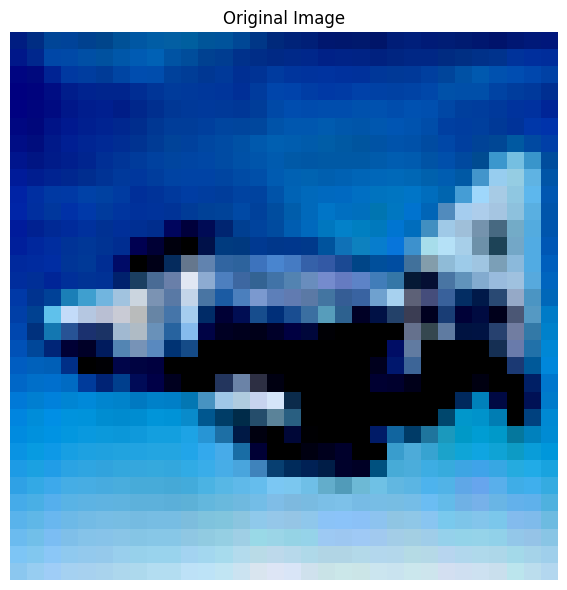

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


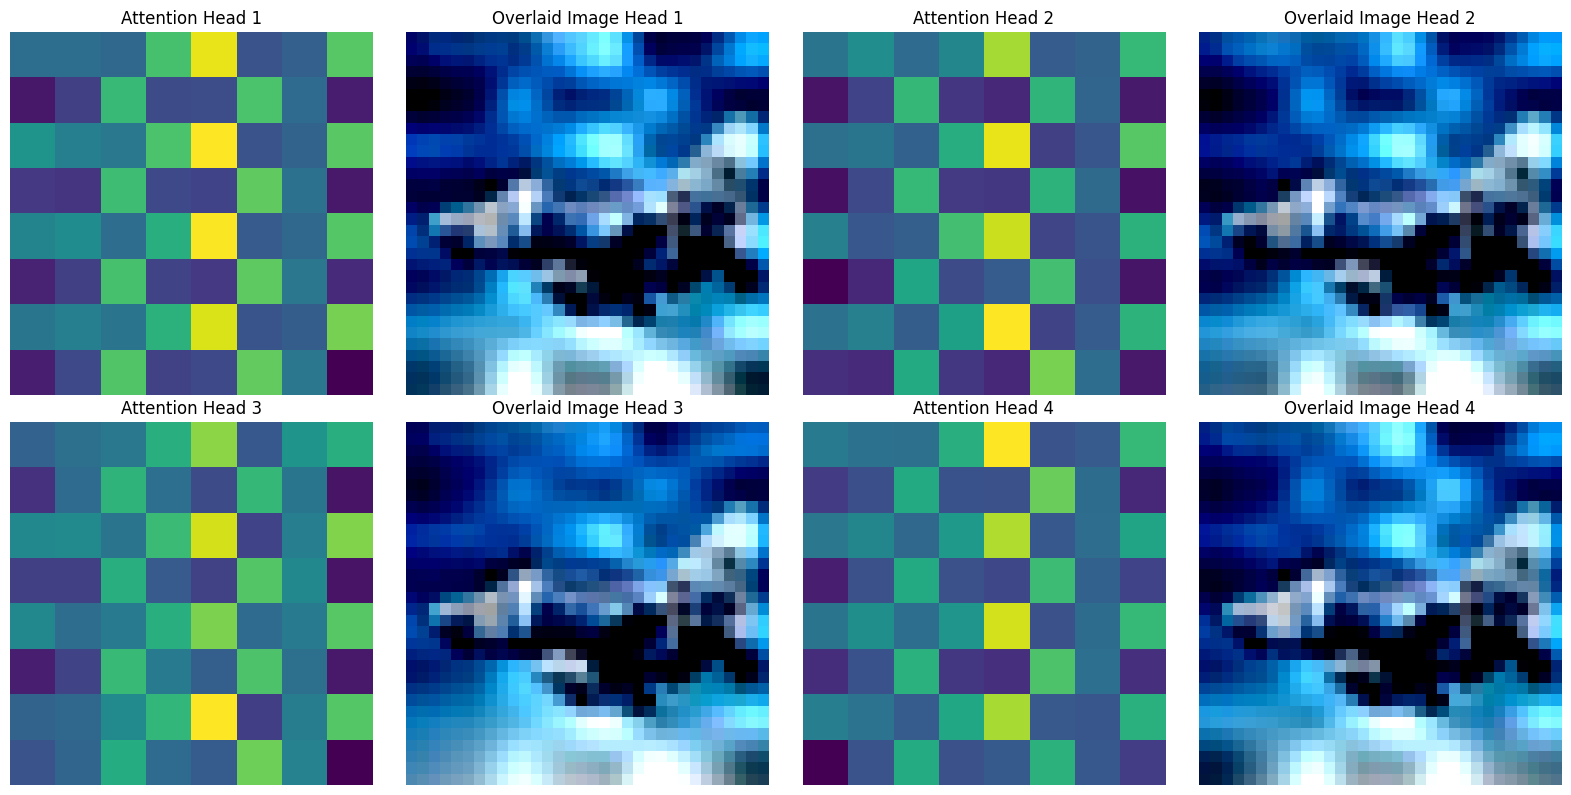

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


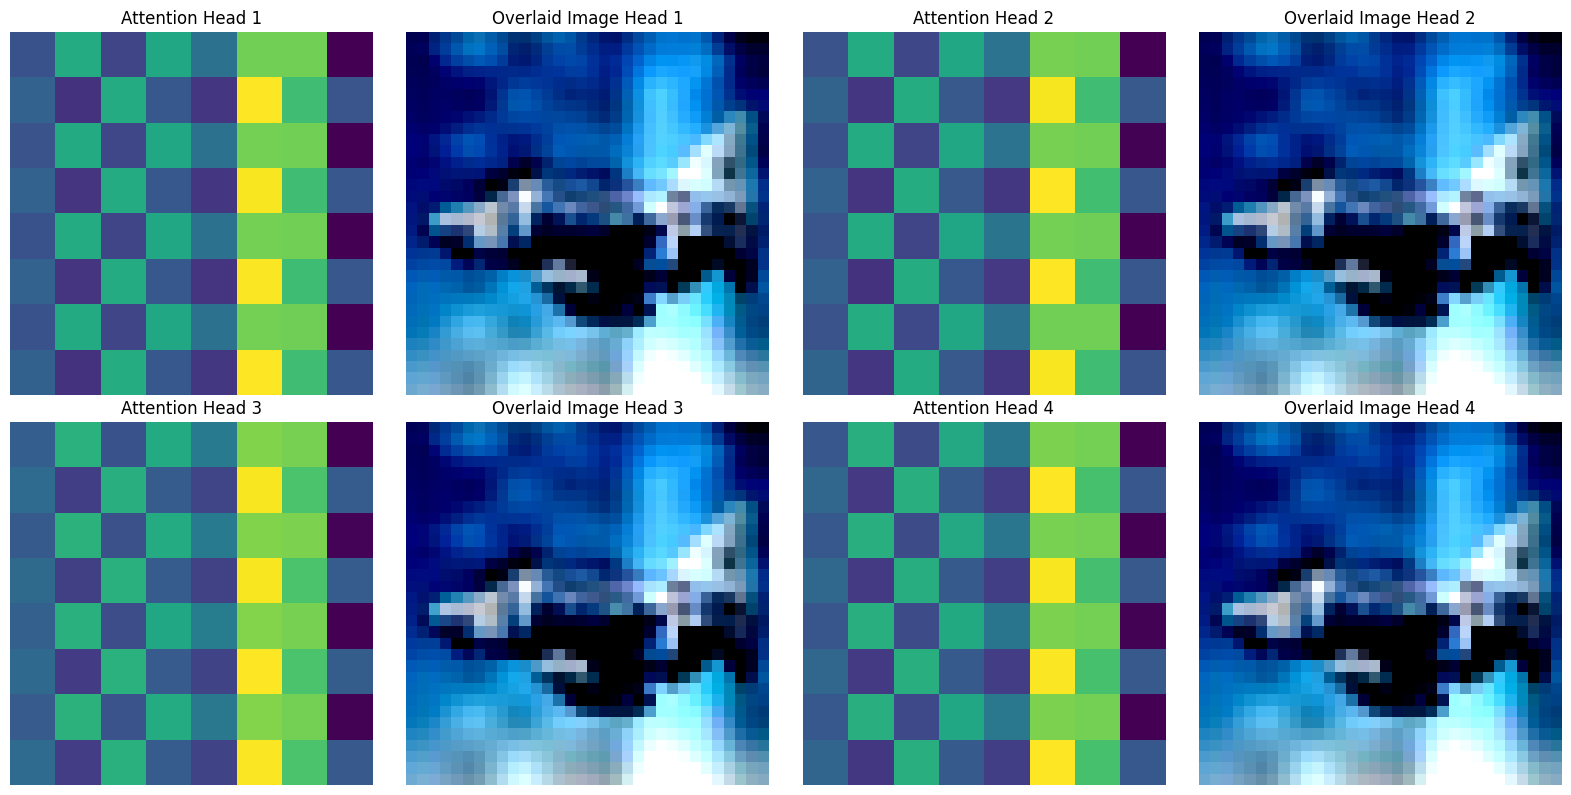

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


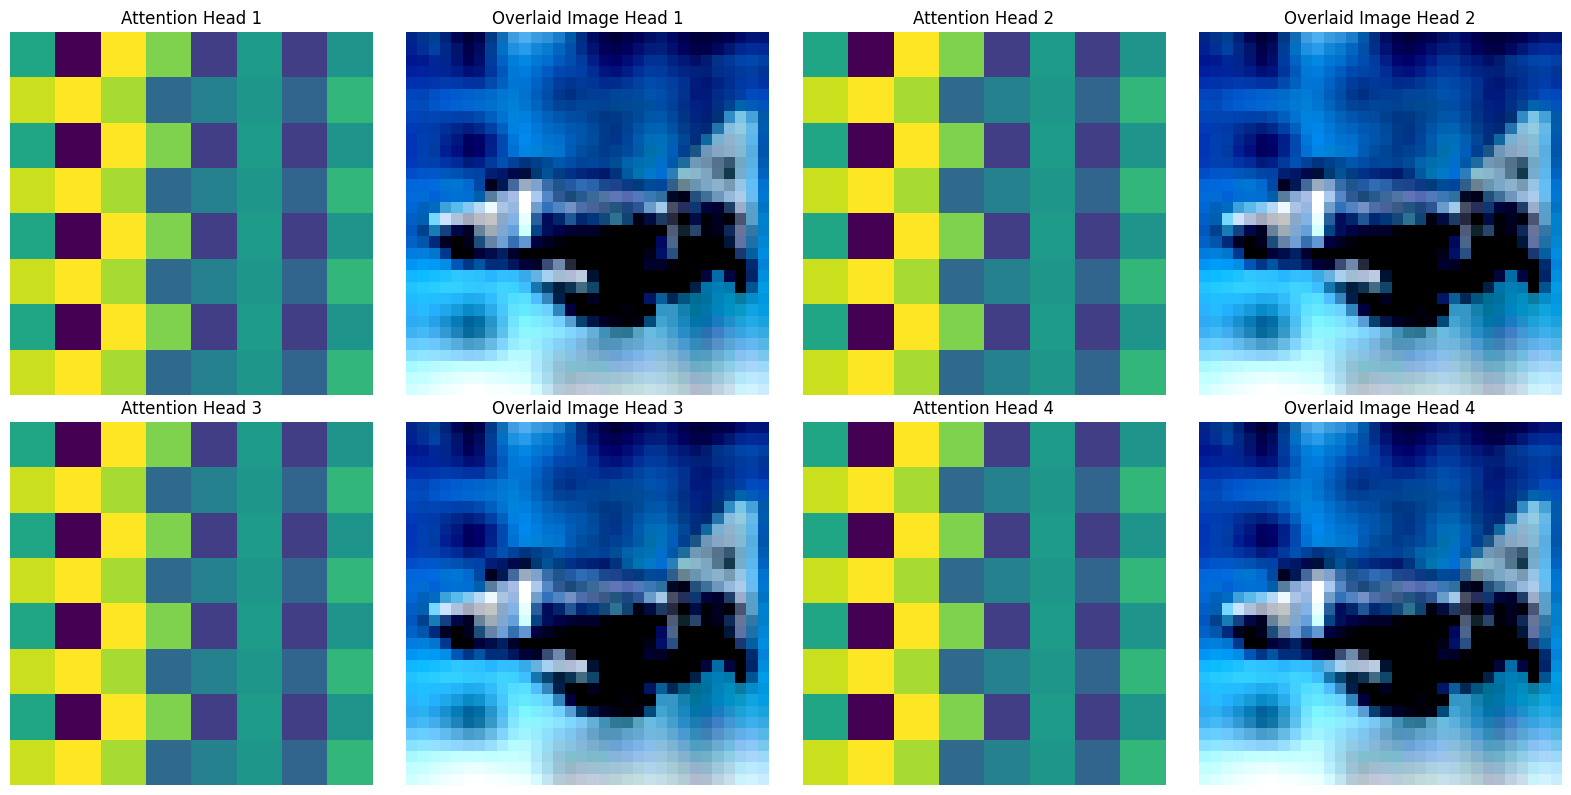

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


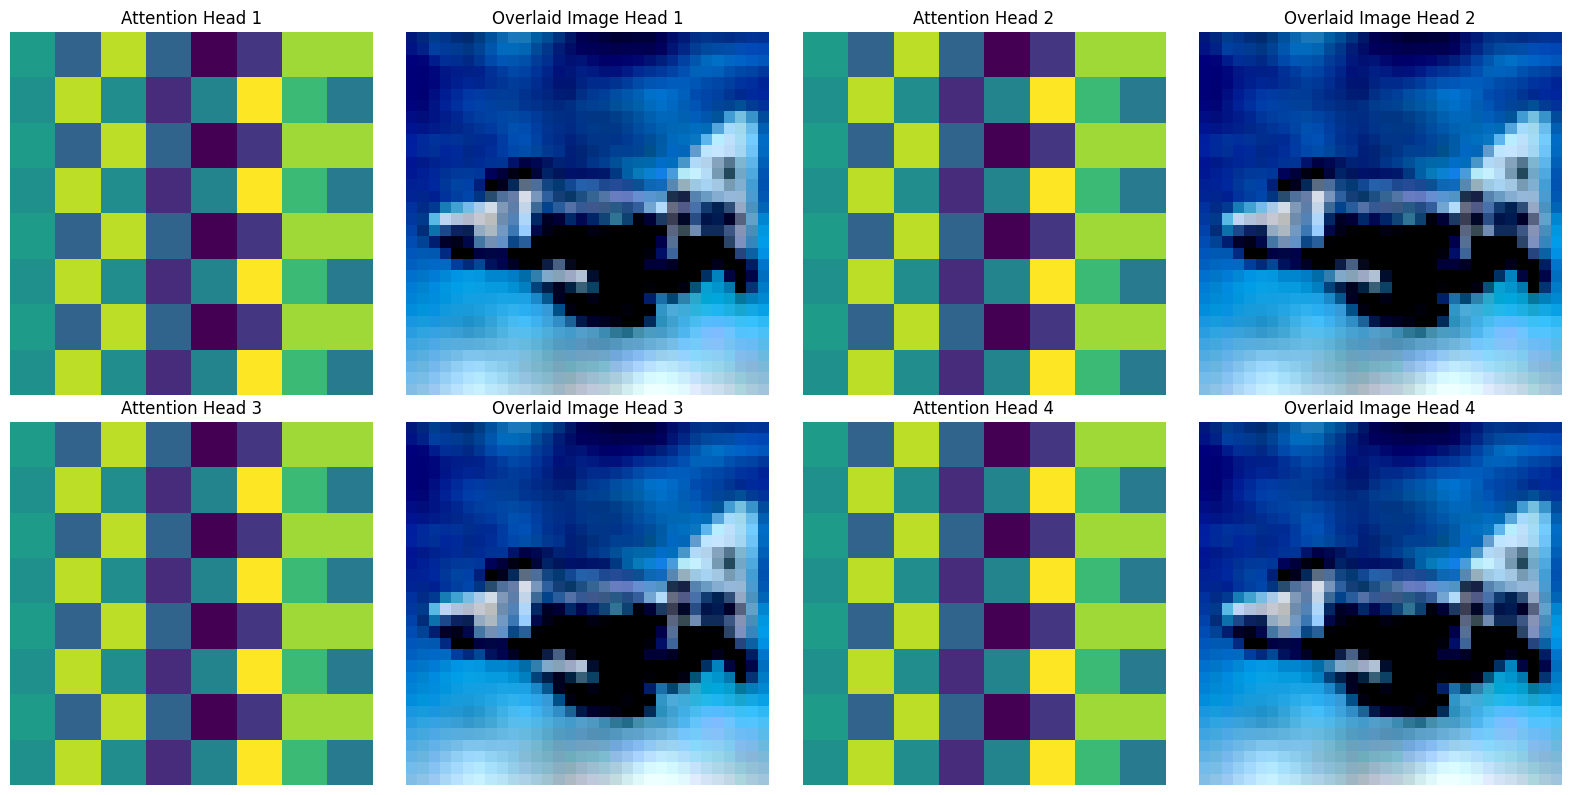

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


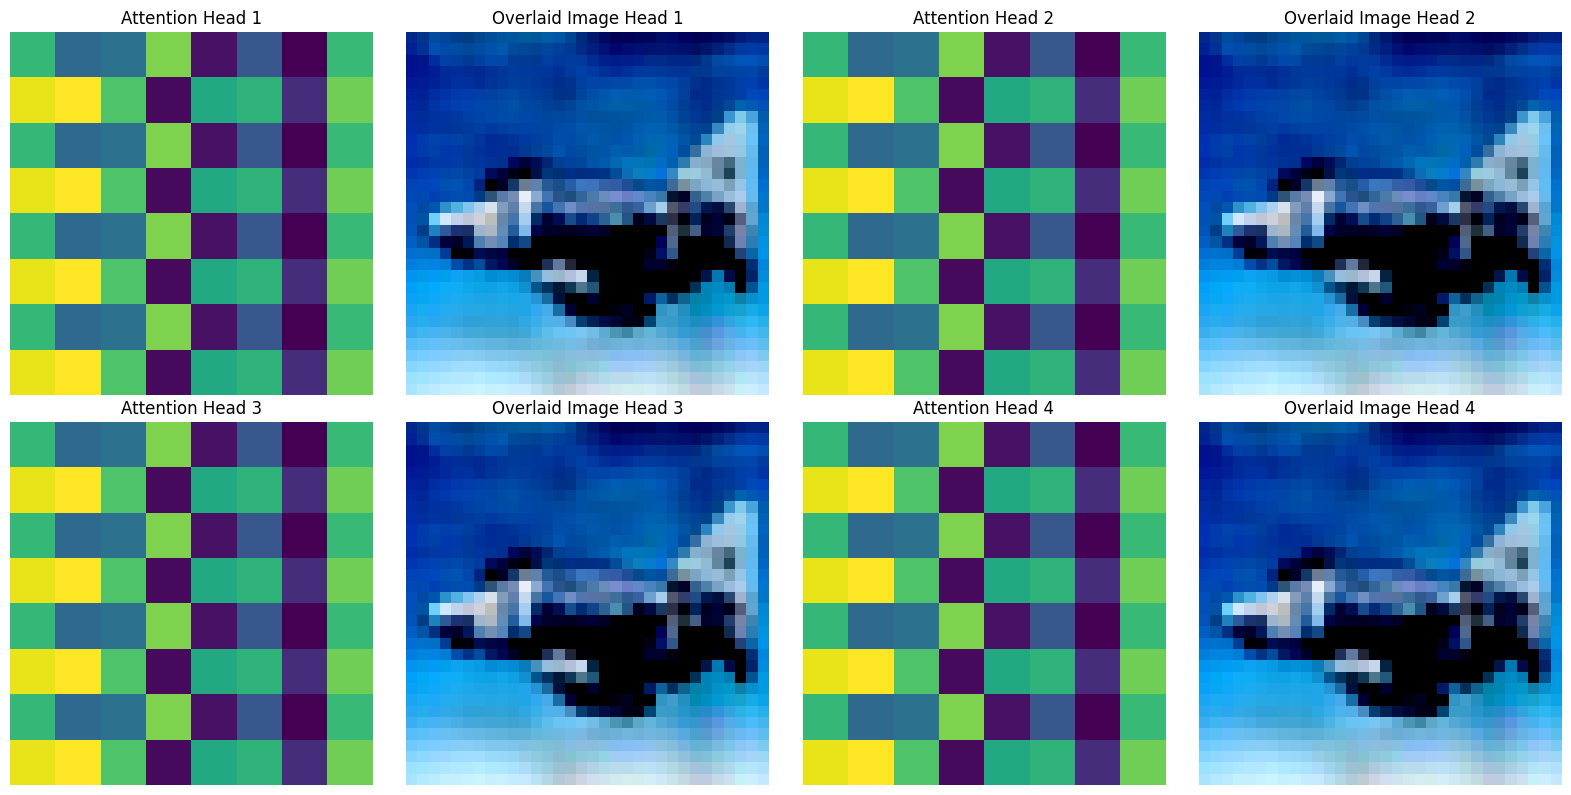

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


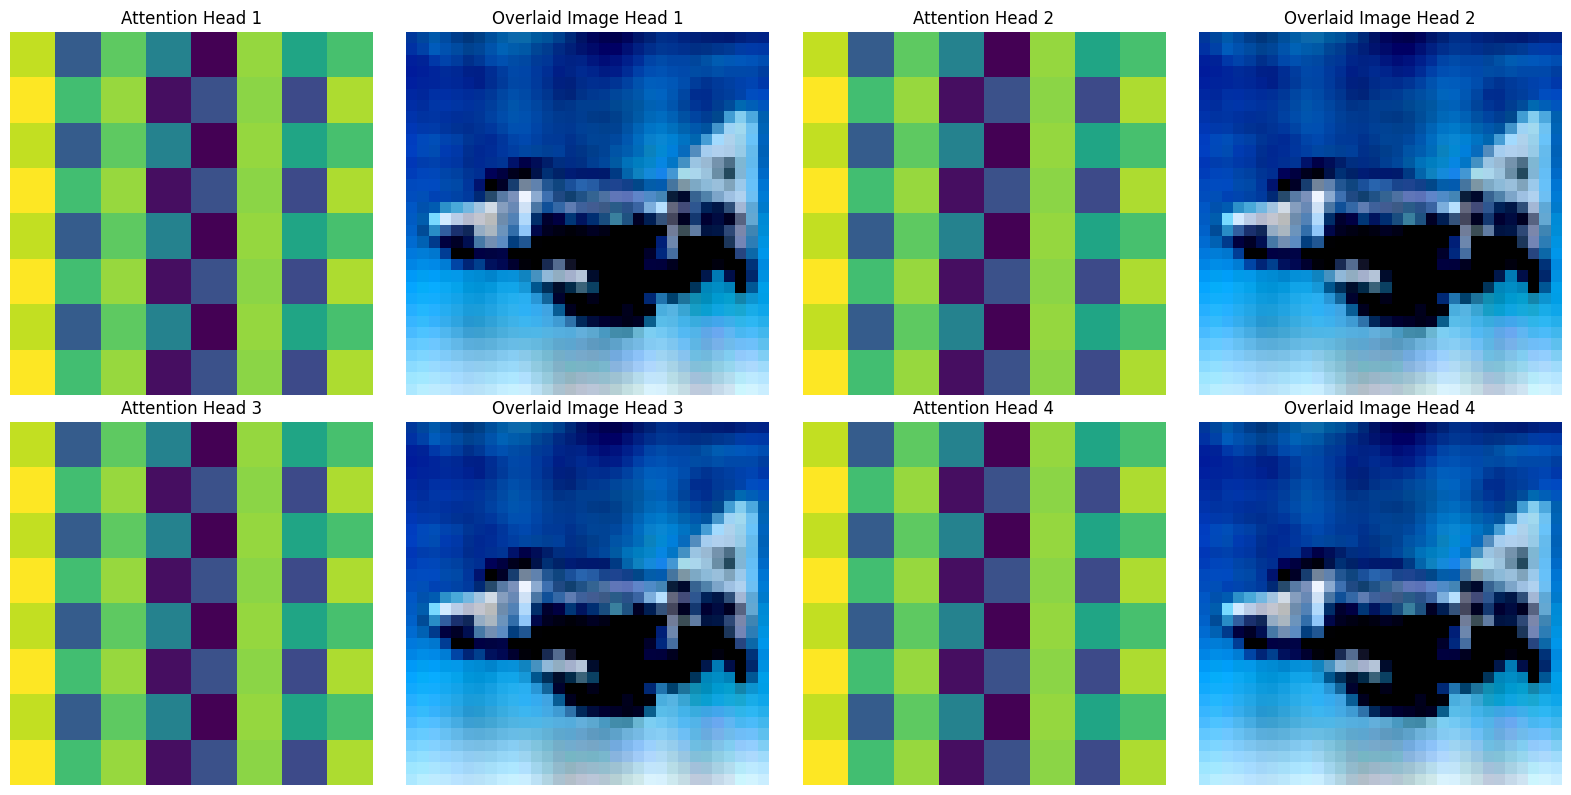

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


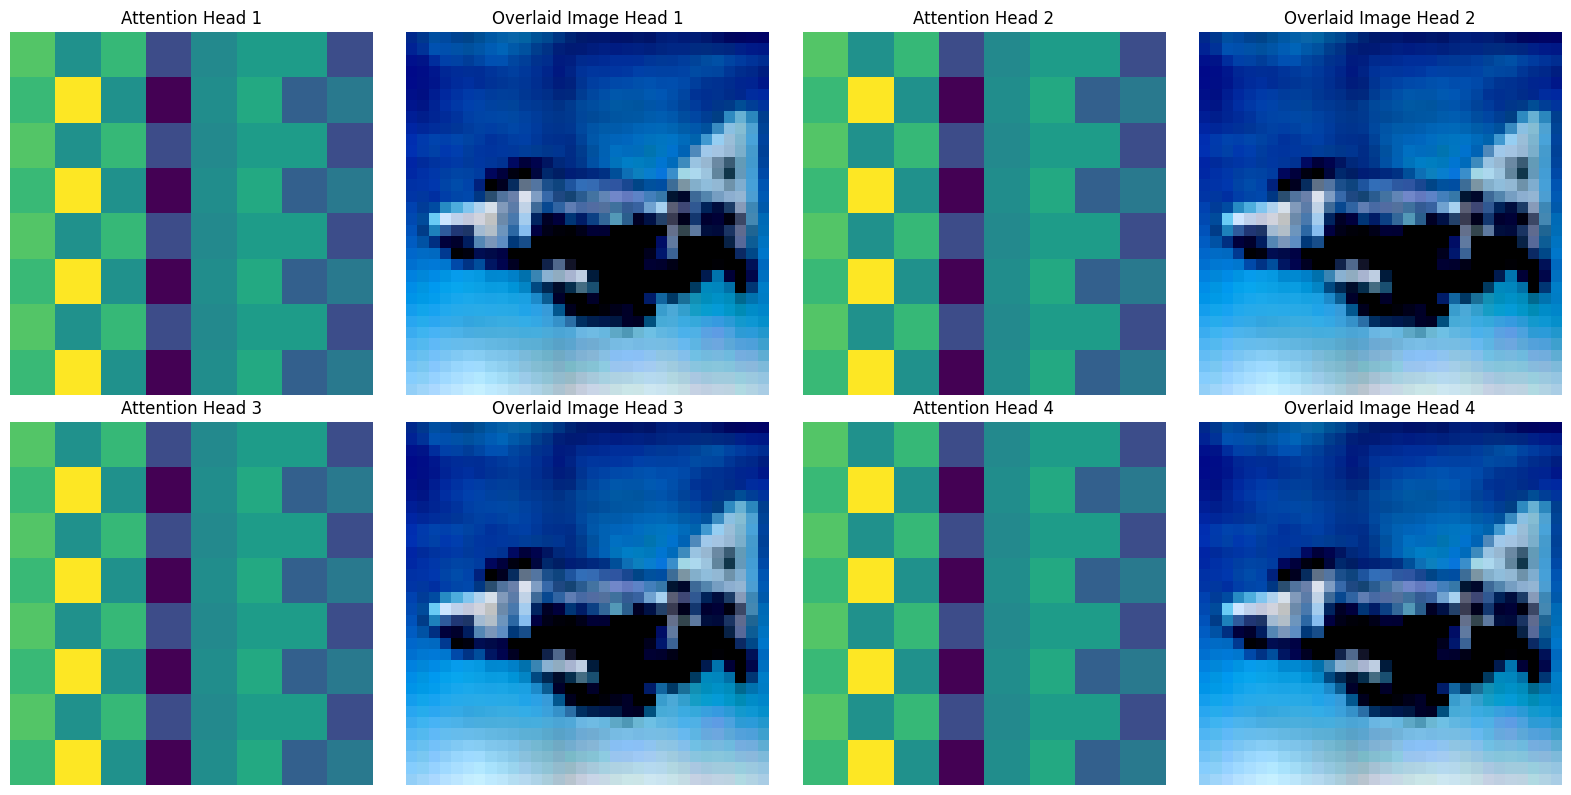

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


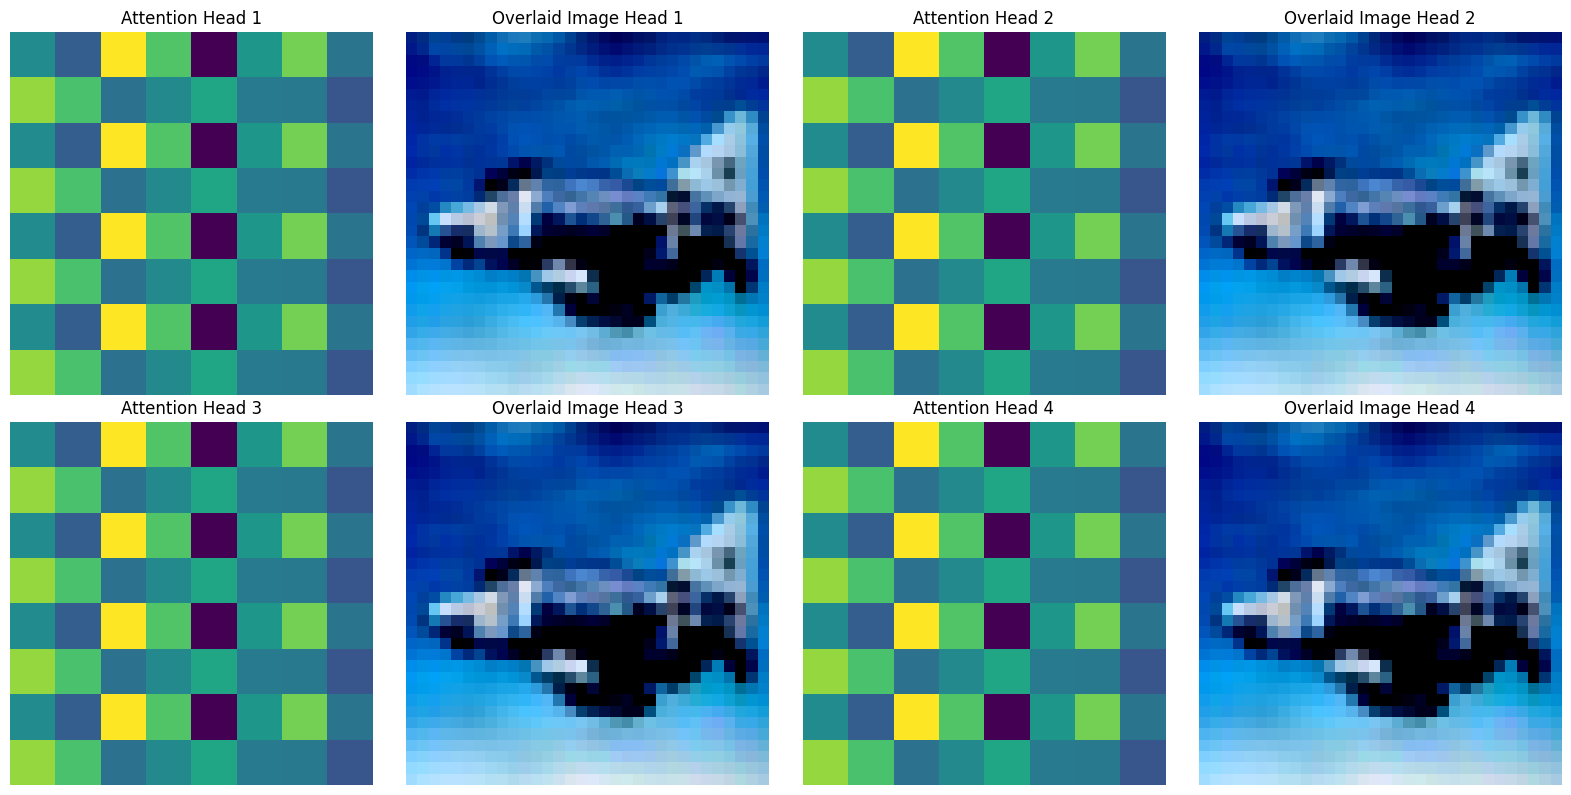

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


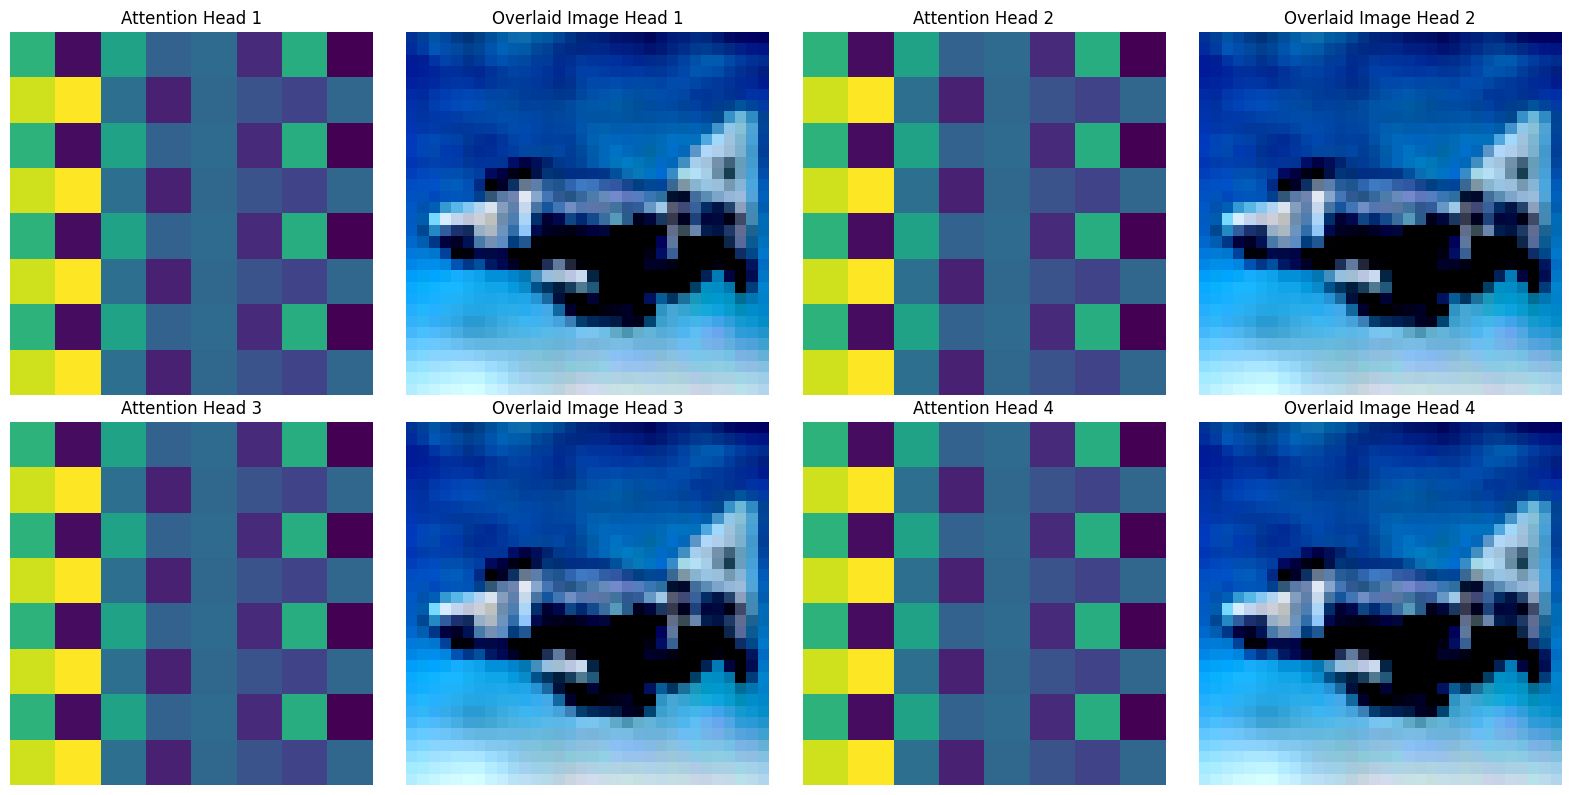

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


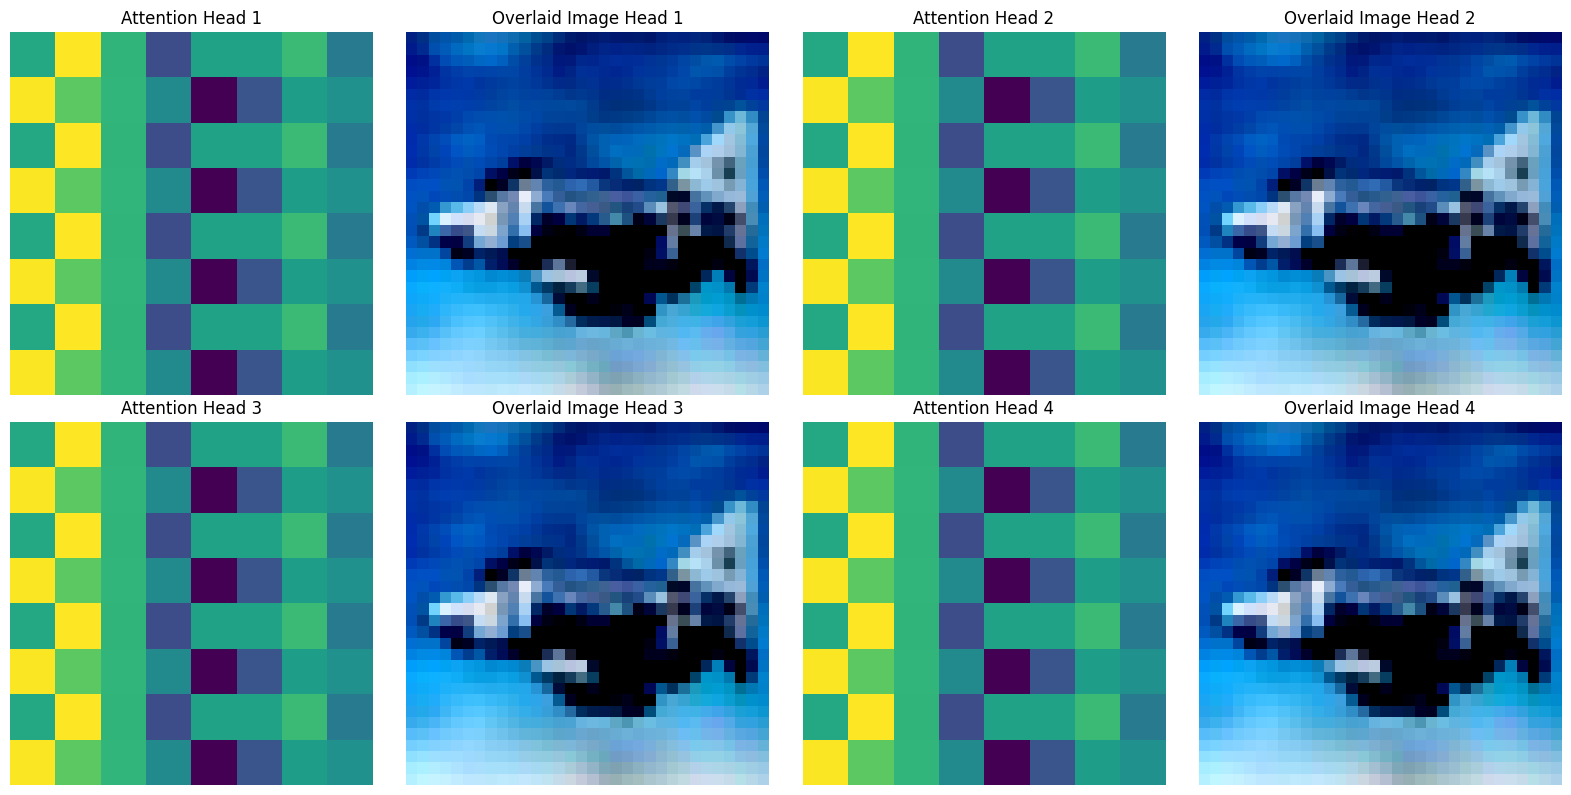

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


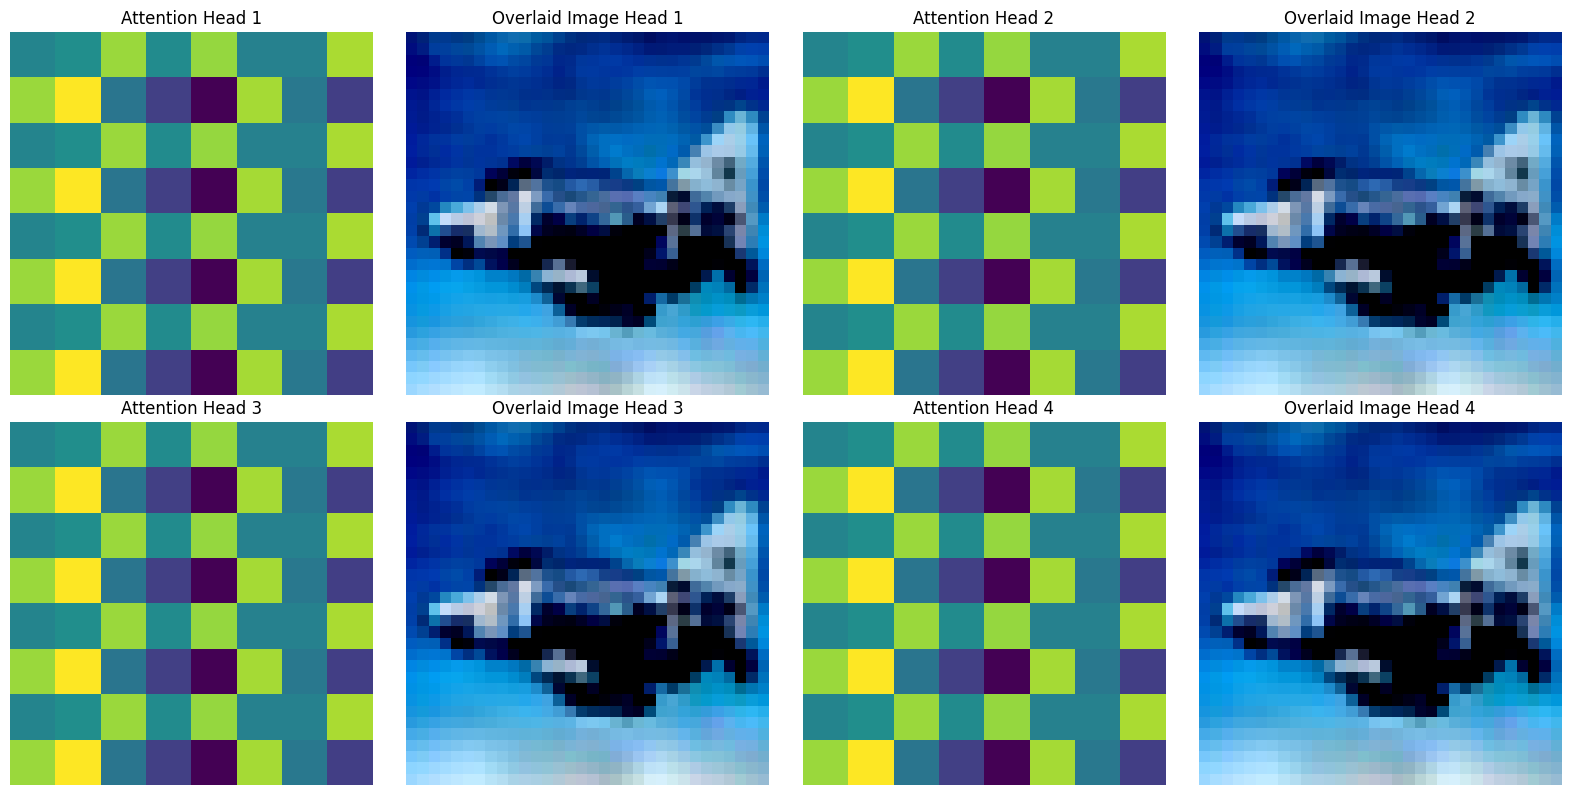

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


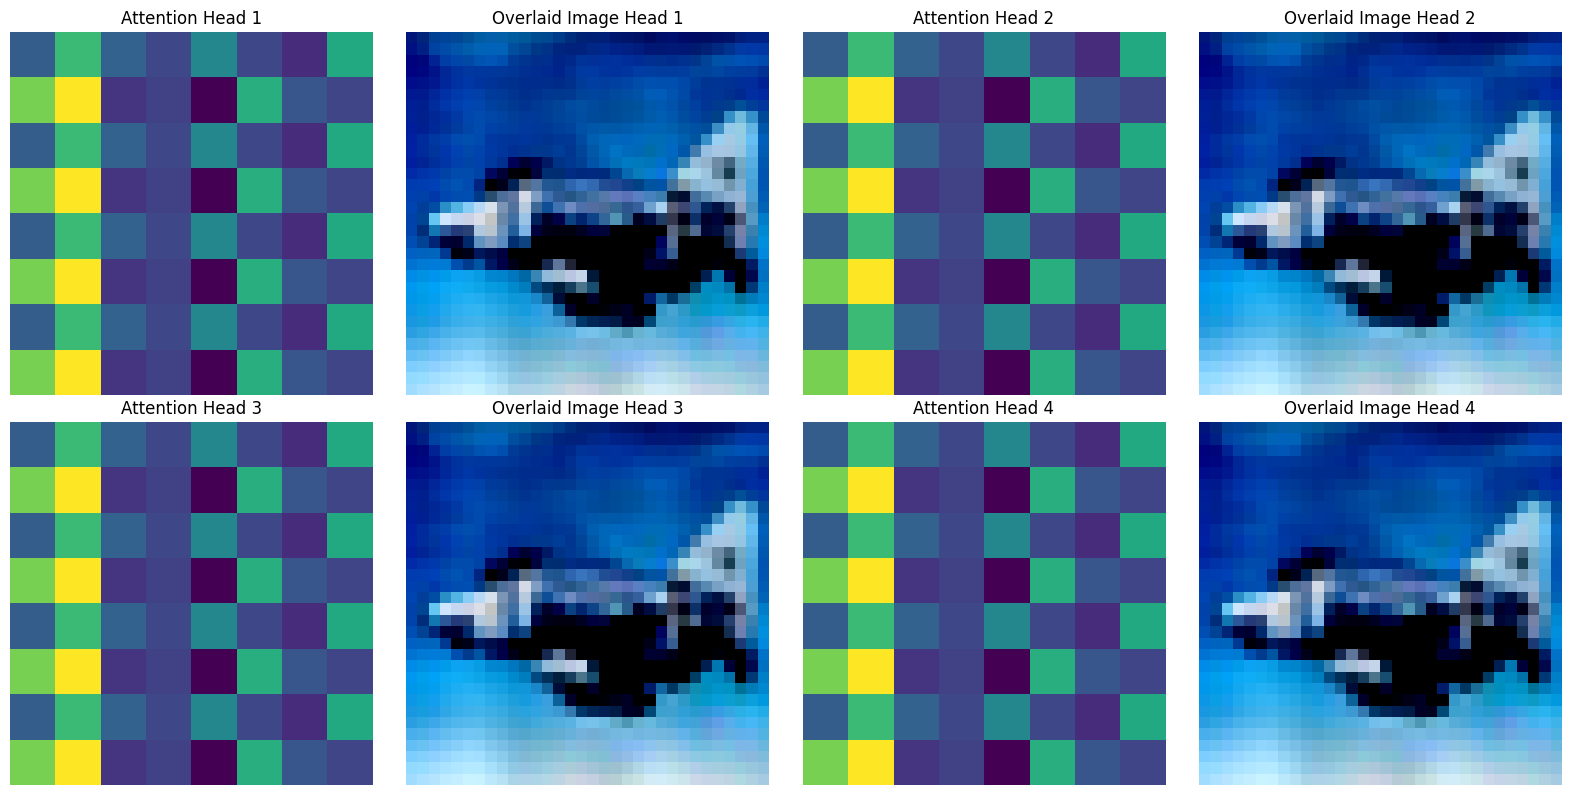

In [322]:
# Assuming 'model' is your trained Vision Transformer model
# Assuming 'trainloader' is your DataLoader containing the training data

# Get one batch of data from the train loader
dataiter = iter(trainloader)
images, _ = next(dataiter)  # Retrieve one batch of images and labels
 # Retrieve one batch of images and labels
image = images[0]  # Select the first image from the batch


# Call the plot_attention_map function with the selected image
plot_attention_map(model_custom, image)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


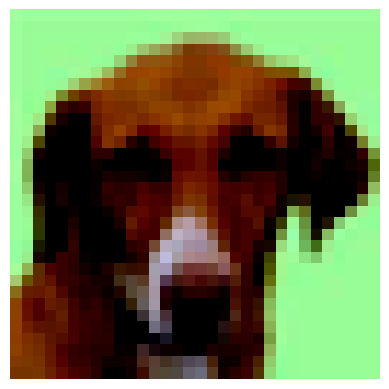

In [232]:
image_np = image.numpy()

# If the image is normalized, you may need to denormalize it before displaying
# Denormalization example (assuming the image is normalized with mean=0.5 and std=0.5)
# image_np = image_np * 0.5 + 0.5

# Plot the image
plt.imshow(np.transpose(image_np, (1, 2, 0)))  # Transpose the dimensions for visualization
plt.axis('off')  # Turn off axis
plt.show()

In [151]:
def show_img(img):
    img = np.asarray(img)
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

def show_img2(img1, img2, alpha=0.8):
    img1 = np.asarray(img1)
    img2 = np.asarray(img2)
    plt.figure(figsize=(10, 10))
    plt.imshow(img1)
    plt.imshow(img2, alpha=alpha)
    plt.axis('off')
    plt.show()

def my_forward_wrapper(attn_obj):
    def my_forward(x):
        B, N, C = x.shape
        qkv = attn_obj.qkv(x).reshape(B, N, 3, attn_obj.n_heads, C // attn_obj.n_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)   # make torchscript happy (cannot use tensor as tuple)

        attn = (q @ k.transpose(-2, -1)) * attn_obj.scales
        attn = attn.softmax(dim=-1)
        attn = attn_obj.attn_drop(attn)
        attn_obj.attn_map = attn
        attn_obj.cls_attn_map = attn[:, :, 0, 2:]

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = attn_obj.proj(x)
        x = attn_obj.proj_drop(x)
        return x
    return my_forward

In [141]:
from PIL import Image

In [152]:
# img = Image.open('n02102480_Sussex_spaniel.JPEG')
x = image

model = model_custom
model.blocks[-1].attn.forward = my_forward_wrapper(model.blocks[-1].attn)

# y = model(x.unsqueeze(0))
attn_map = model.blocks[-1].attn.attn_map.mean(dim=1).squeeze(0).detach()
# cls_weight = model.blocks[-1].attn.cls_attn_map.mean(dim=1).view(14, 14).detach()

img_resized = x.permute(1, 2, 0) * 0.5 + 0.5
# cls_resized = F.interpolate(cls_weight.view(1, 1, 14, 14), (224, 224), mode='bilinear').view(224, 224, 1)

# show_img(image)
show_img(attn_map)
# show_img(cls_weight)
show_img(img_resized)
# show_img2(img_resized, cls_resized, alpha=0.8)

AttributeError: 'Attention' object has no attribute 'attn_map'

In [ ]:
image

In [ ]:
# take one image from training set and visualize the attention maps
# import matplotlib.pyplot as plt
# import numpy as np

# def plot_attention_map(model, image, n_heads=4, n_rows=2, n_cols=2):
#     model.eval()
#     image = image.unsqueeze(0)
#     with torch.no_grad():
#         outputs = model.patch_embed(image)
#         cls_token = model.cls_token.expand(1, -1, -1)
#         outputs = torch.cat((cls_token, outputs), dim=1)
#         outputs = outputs + model.pos_embed
#         outputs = model.pos_drop(outputs)
#         for i, block in enumerate(model.blocks):
#             outputs = block.attn(outputs)
#             if i + 1 in [1, 2, 3, 4]:
#                 for j in range(n_heads):
#                     plt.figure(figsize=(15, 15))
#                     ax = plt.subplot(n_rows, n_cols, j + 1)
#                     ax.set_title(f'Head {j + 1}')
#                     attn_map = outputs.squeeze(0)[1:].reshape(n_heads, -1, 8, 8)[j].cpu().numpy()
#                     attn_map = np.mean(attn_map, axis=0)
#                     plt.imshow(attn_map, cmap='viridis')
#                     plt.axis('off')
#                 plt.show()

# Example usage:


In [106]:
import matplotlib.pyplot as plt

def train_model(model, trainloader, validloader, n_epochs, lr, device):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.to(device)
    
    train_loss_history = []
    valid_loss_history = []
    train_acc_history = []
    valid_acc_history = []

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        correct_valid = 0
        total_valid = 0
        
        # Training phase
        model.train()
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total_train += labels.size(0)
            correct_train += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_accuracy = 100 * correct_train / total_train
        
        # Validation phase
        model.eval()
        running_loss = 0.0
        with torch.no_grad():
            for data in validloader:
                inputs, labels = data[0].to(device), data[1].to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total_valid += labels.size(0)
                correct_valid += predicted.eq(labels).sum().item()

        valid_loss = running_loss / len(validloader)
        valid_accuracy = 100 * correct_valid / total_valid
        
        # Print training and validation loss and accuracy
        print('[Epoch %d/%d] Train Loss: %.4f, Train Acc: %.2f%% | Valid Loss: %.4f, Valid Acc: %.2f%%' % (
            epoch + 1, n_epochs, train_loss, train_accuracy, valid_loss, valid_accuracy))
        
        # Save loss and accuracy history for plotting
        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)
        train_acc_history.append(train_accuracy)
        valid_acc_history.append(valid_accuracy)

    print('Finished Training')
    
    # Plotting loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss_history, label='Training Loss')
    plt.plot(valid_loss_history, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
    
    # Plotting accuracy curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_acc_history, label='Training Accuracy')
    plt.plot(valid_acc_history, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

# Example usage:
# train_model(model, trainloader, validloader, n_epochs=10, lr=0.001, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))


In [108]:
model_custom = VisionTransformer(**custom_config)
train_model(model_custom, trainloader,testloader, 1, 0.001, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

KeyboardInterrupt: 

# Verification

In [ ]:
%pip install timm

In [66]:
%pip install .

Note: you may need to restart the kernel to use updated packages.


ERROR: Directory '.' is not installable. Neither 'setup.py' nor 'pyproject.toml' found.

[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import numpy as np
import torch
import timm 
from custom import VisionTransformer

In [ ]:
# helper function to count number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def assert_tensors_equal(t1, t2):
    assert t1.shape == t2.shape, f"Shapes do not match: {t1.shape} and {t2.shape}"
    assert torch.allclose(t1, t2, atol=1e-4), "Tensors do not match"

model_name = "vit_base_patch16_384"
model = timm.create_model(model_name, pretrained=True)
model.eval()

custom_config = {"img_size": 384, "patch_size": 16, "in_channels": 3, "n_classes": 1000, "emb_size": 768, "depth": 12, "n_heads": 12, "mlp_ratio": 4.0, "qkv_bias": True, "drop_prob": 0.0, "attn_drop_prob": 0.0}

custom_model = VisionTransformer(**custom_config)
custom_model.eval()

In [61]:
torch.randn(1, 1, 5).expand(2, -1, -1)

tensor([[[-0.8924, -1.2784, -0.6579, -1.6928, -0.0461]],

        [[-0.8924, -1.2784, -0.6579, -1.6928, -0.0461]]])

In [13]:
module = torch.nn.Dropout(0.4)

In [53]:
sum(p.numel() for p in module.parameters() if p.requires_grad)

6

In [ ]:
# elementwise affine = False means that the layer will not learn the affine parameters (bias and scale)
# only last dimension is normalized

In [48]:
inp = torch.tensor([[1, 2, 3], [4, 5, 6]], dtype=torch.float32)
n_samples, n_features = inp.shape
module = torch.nn.LayerNorm(n_features, elementwise_affine=True)

In [58]:
module(inp).mean(-1)

tensor([2., 2.], grad_fn=<MeanBackward1>)

In [57]:
module.bias.data += 1
module.weight.data += 10

In [40]:
a = torch.ones(3,2,4,5)

In [ ]:
a

In [ ]:
a.flatten(2)

In [20]:
module(a)

tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]])

In [18]:
module.eval()

Dropout(p=0.4, inplace=False)

In [19]:
module.training

False